In [1]:
import pandas as pd
%matplotlib inline
import tangos
import tangos.examples.mergers as mergers

import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
h = 0.6776942783267969

from tangos_halo_module.halo_properties import track_halo_property, get_timesteps, ID_to_sim_halo_snap, infall_final_n_particles, infall_final_coordinates, apocentric_distance, disruption_time, accretion_time, orbit_interpolation, infall_velocity, quenching_time, max_sSFR_time, max_mass_time 
from tangos_halo_module.path import get_file_path, get_halo_snap_num, read_file
from tangos_halo_module.halos import ID_to_tangos_halo, get_survivors, get_main_progenitor_branch, get_zombies, get_host, get_survivor_IDs, get_zombie_IDs, blockPrint, enablePrint, tangos_to_pynbody_halo

In [2]:
# match = pd.read_csv('haloID_match.csv')
# DebIDs = match['Deb_ID'].to_numpy()
# HollisIDs = match['Hollis_ID'].to_numpy()
# sims = match['Simulation'].to_numpy()

# host = get_host(simulation='h148')
# tangos_to_pynbody_halo(tangos_halo=host, simulation='h148')

In [5]:
# d = pd.read_csv('Data.csv')
# ids = d['IDs'].to_numpy()
# print(ids)

# d.keys()
# len(ids)

In [7]:
# This cell takes ~10 minutes to run...
ids=[]
for sim in ['h148', 'h229', 'h242', 'h329']:
    ids = ids + get_survivor_IDs(simulation=sim, resolution=100) + get_zombie_IDs(simulation=sim, resolution=100)
print(ids)

In [2]:
# ids=[int(i) for i in ids]
# print(ids)
# np.savetxt('ids100.txt', ids)
ids = np.loadtxt('ids100.txt')
ids=[int(i) for i in ids]
ids

[148409610,
 148409610270,
 14840961090,
 14840961101,
 148409612,
 14840961292,
 148409613,
 1484096189,
 14840962,
 1484096217,
 1484096223,
 14840962297,
 148409623,
 1484096263,
 1484096290,
 14840963,
 1484096306,
 148409636,
 1484096380,
 148409639,
 14840964,
 1484096438,
 148409644,
 148409648,
 1484096563,
 148409662,
 148409669,
 1484096779,
 1484096932,
 1480225104,
 148027562,
 1480275869,
 1480347728,
 14803478,
 1480384109,
 1480384115,
 1480384124,
 1480384163,
 14803846,
 1480384990,
 1480456173,
 1480456309,
 148045663,
 1480512264,
 14805124,
 148051272,
 148051285,
 148051289,
 148064011,
 14807012,
 148070125,
 148070149,
 148070165,
 148089619,
 148097431,
 148102421,
 148102429,
 14810249,
 14811066,
 148115210,
 14812803,
 14812806,
 148153610,
 148153614,
 148192016,
 14821761398,
 14824322,
 14829442,
 229409610,
 22940961327,
 22940961381,
 229409618,
 2294096191,
 229409624,
 22940963661,
 229409645,
 229409646,
 229409648,
 229409659,
 229409667,
 229409689,

In [5]:
# # Initialize dataframe
# column_names = ['ID', 'IDs', 'SFR', 'sSFR', 'stellar_mass', 'new_stellar_mass']
# df = pd.DataFrame(columns = column_names)
# df.to_csv('sSFR_data100.csv', index=False)

In [3]:
# Load routine for getting tracks
def sSFR_track(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, resolution=1000):
    
#     from tangos_halo_module.halos import tangos_to_pynbody_halo, get_main_progenitor_branch

    if ID != 0:
        print('Started ', ID)
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
        print(simulation, status, halo_id, snap_num)
        tangos_halo = ID_to_tangos_halo(ID=ID, resolution=resolution)
    
    # Satellite MPB ids
    MPB, MPB_ids = get_main_progenitor_branch(tangos_halo=tangos_halo, simulation=simulation, resolution=resolution)
    print(MPB_ids)
    print(MPB)
    # Store and recall
    # Host MPB and ids
    host = get_host(simulation=simulation, resolution=resolution)
    host_MPB, host_ids = get_main_progenitor_branch(tangos_halo=host, simulation=simulation, 
                                                    resolution=resolution)

    # Only consider halo while separate from host
    MPB_ids[MPB_ids==host_ids] = 0
    print(MPB_ids)

    for i in range(len(MPB_ids)):
        if MPB_ids[i]!=0:
            if len(str(MPB[i]))>6:
                MPB_ids[i]=get_halo_snap_num(tangos_halo=MPB[i])[2]
            else: 
                MPB_ids[i]=0
    print('MPB new IDs: ', MPB_ids)
    IDs_track = np.zeros(0)
    SFR_track = np.zeros(0)
    sSFR_track = np.zeros(0)
    mass_track = np.zeros(0)
    new_mass_track = np.zeros(0)

    for index, idx in enumerate(MPB_ids):
        print(idx)
        if idx==0:
            IDs_track = np.concatenate((IDs_track, [-1]), axis=None)
            SFR_track = np.concatenate((SFR_track, [-1]), axis=None)
            sSFR_track = np.concatenate((sSFR_track, [-1]), axis=None)
            mass_track = np.concatenate((mass_track, [-1]), axis=None)
            new_mass_track = np.concatenate((new_mass_track, [-1]), axis=None)
        elif len(str(MPB[index]))<6:
            IDs_track = np.concatenate((IDs_track, [idx]), axis=None)
            SFR_track = np.concatenate((SFR_track, [-1]), axis=None)
            sSFR_track = np.concatenate((sSFR_track, [-1]), axis=None)
            mass_track = np.concatenate((mass_track, [-1]), axis=None)
            new_mass_track = np.concatenate((new_mass_track, [-1]), axis=None)
        else:
            tang_halo = ID_to_tangos_halo(ID=idx, resolution=resolution)
            print(tang_halo)
            pyn_halo = tangos_to_pynbody_halo(tangos_halo=tang_halo, simulation=simulation, resolution=resolution)
            mass = np.asarray(pyn_halo.s['mass'].in_units('Msol'))
            age = pyn_halo.properties['time'].in_units('Gyr') - pyn_halo.s['tform'].in_units('Gyr') #SimArray in Gyr
            new_mass = np.sum(mass[age <= 0.1]) # Formed within last 100 Myr
            total_mass = np.sum(mass)
            SFR = new_mass/1e8
            sSFR = SFR/total_mass
            IDs_track = np.concatenate((IDs_track, [idx]), axis=None)
            SFR_track = np.concatenate((SFR_track, [SFR]), axis=None)
            sSFR_track = np.concatenate((sSFR_track, [sSFR]), axis=None)
            mass_track = np.concatenate((mass_track, [total_mass]), axis=None)
            new_mass_track = np.concatenate((new_mass_track, [new_mass]), axis=None)
    print(SFR_track, sSFR_track, mass_track, new_mass_track)
    dat = {'ID': ID,
           'IDs': [IDs_track],
           'SFR': [SFR_track], 
           'sSFR': [sSFR_track], 
           'stellar_mass': [mass_track], 
           'new_stellar_mass': [new_mass_track],}
    df = pd.DataFrame(data=dat)
    return df
    
df = pd.read_csv('sSFR_data100.csv')
completed_ids = df['ID'].to_numpy()
len(completed_ids)

3

In [5]:
# tangos.init_db("simulation_database/h148.db")
# timesteps = tangos.get_simulation("snapshots").timesteps
# tang_halo = timesteps[-1][12]
# MPB, MPB_ids = get_main_progenitor_branch(tangos_halo=tang_halo, simulation='h148')
# tang_halo=MPB[-14]
# #print(tang_halo_id)
# #tang_halo = timesteps[-14][12]
# # ID=148409610
# # tang_halo = ID_to_tangos_halo(ID=ID)
# print(tang_halo)
# pyn_halo = tangos_to_pynbody_halo(tangos_halo=tang_halo, simulation='h148')
# mass = np.asarray(pyn_halo.s['mass'].in_units('Msol'))
# print("Mass: ", mass)
# print(len(mass))
# age = pyn_halo.properties['time'].in_units('Gyr') - pyn_halo.s['tform'].in_units('Gyr') #SimArray in Gyr
# print("Age: ", age)
# new_mass = np.sum(mass[age <= 0.1]) # Formed within last 100 Myr
# print("New Mass: ", new_mass)
# total_mass = np.sum(mass)
# print("Total Mass: ", total_mass)
# SFR = new_mass/(1e8)
# print("SFR: ", SFR)
# sSFR = SFR/total_mass
# print("sSFR: ", sSFR)
sat_df = sSFR_track(ID='14840961101', resolution=100)
sat_df

Started  14840961101
h148 Survivor 1101 4096
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.  475.  489.  630.  731.  709.  680.  636.
  633.  654.  664.  773.  634.  669.  795.  869.  966.  985.  986.  981.
  965.  959.  956.  986. 1032. 1066. 1101.]
[-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0
 -1.0 -1.0 -1.0
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH.001269/halo_475' | NDM=4782 Nstar=21 Ngas=0>
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH.001280/halo_489' | NDM=4634 Nstar=21 Ngas=0>
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH.001408/halo_630' | NDM=3245 Nstar=21 Ngas=0>
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH.001536/halo_731' | NDM=2694 Nstar=21 Ngas=0>
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH.001740/halo_709' | NDM=2662 Nstar=21 Ngas=0>
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH.001920/halo_680' | NDM=2720 Nstar=21 Ngas=0>
 <Halo 'snapshots/h148.cosmo50PLK.3072g3HbwK1BH

ID                                                IDs  \
0  14840961101  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....   

                                                 SFR  \
0  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....   

                                                sSFR  \
0  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....   

                                        stellar_mass  \
0  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....   

                                    new_stellar_mass  
0  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....

In [6]:
plt.plot(pyn_halo.s['x'],pyn_halo.s['y'],'.')

NameError: name 'pyn_halo' is not defined

In [ ]:
count=0
while True:
    try:
        print('Watch me go for the ', count, 'th time...')
        for idx in ids:
            if idx in completed_ids:
                print('Already Exists ', idx)
                pass
            else:
                print('Started ', idx)
                sat_df = sSFR_track(ID=idx, resolution=100)
                df = pd.concat([df, sat_df])
                df.to_csv('sSFR_data100.csv', index=False)
                completed_ids = np.concatenate((completed_ids, [idx]), axis=None)
                print('Finished ', idx)
    except: 
        count+=1
        continue

Watch me go for the  0 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7 th time...


Watch me go for the  228 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  229 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  230 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  231 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  232 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  233 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  234 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the 

Already Exists  14840961090
Started  14840961101
Watch me go for the  497 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  498 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  499 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  500 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  501 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  502 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  503 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  1484

Started  14840961101
Watch me go for the  724 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  725 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  726 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  727 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  728 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  729 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  730 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101

Watch me go for the  951 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  952 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  953 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  954 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  955 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  956 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  957 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the 

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1179 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1180 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1181 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1182 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1183 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1184 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1185 th time...
Already Exist

Watch me go for the  1451 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1452 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1453 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1454 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1455 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1456 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1457 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Watch me go for the  1672 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1673 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1674 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1675 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1676 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1677 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1678 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Started  14840961101
Watch me go for the  1963 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1964 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1965 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1966 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1967 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1968 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  1969 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  1484

Started  14840961101
Watch me go for the  2312 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2313 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2314 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2315 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2316 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2317 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2318 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  1484

Already Exists  14840961090
Started  14840961101
Watch me go for the  2560 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2561 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2562 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2563 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2564 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2565 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2566 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exist

Watch me go for the  2855 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2856 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2857 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2858 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2859 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2860 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  2861 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Watch me go for the  3178 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3179 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3180 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3181 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3182 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3183 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3184 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Watch me go for the  3450 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3451 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3452 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3453 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3454 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3455 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3456 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Started  14840961101
Watch me go for the  3769 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3770 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3771 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3772 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3773 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3774 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  3775 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  1484

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4119 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4120 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4121 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4122 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4123 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4124 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4125 th time...
Already Exist

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4465 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4466 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4467 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4468 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4469 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4470 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4471 th time...
Already Exist

Watch me go for the  4814 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4815 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4816 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4817 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4818 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4819 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  4820 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Started  14840961101
Watch me go for the  5087 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5088 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5089 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5090 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5091 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5092 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5093 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  1484

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5360 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5361 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5362 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5363 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5364 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5365 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5366 th time...
Already Exists  148409610
Already Exist

Already Exists  14840961090
Started  14840961101
Watch me go for the  5678 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5679 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5680 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5681 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5682 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5683 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5684 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exist

Started  14840961101
Watch me go for the  5996 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5997 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5998 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  5999 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6000 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6001 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6002 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  1484

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6269 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6270 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6271 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6272 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6273 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6274 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6275 th time...
Already Exists  148409610
Already Exist

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6536 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6537 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6538 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6539 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6540 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6541 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6542 th time...
Already Exist

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6730 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6731 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6732 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6733 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6734 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6735 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  6736 th time...
Already Exists  148409610
Already Exist

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7087 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7088 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7089 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7090 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7091 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7092 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7093 th time...
Already Exists  148409610
Already Exist

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7397 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7398 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7399 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7400 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7401 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7402 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7403 th time...
Already Exists  148409610
Already Exist

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7769 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7770 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7771 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7772 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7773 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7774 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  7775 th time...
Already Exist

Already Exists  14840961090
Started  14840961101
Watch me go for the  8176 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8177 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8178 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8179 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8180 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8181 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8182 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exist

Already Exists  14840961090
Started  14840961101
Watch me go for the  8432 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8433 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8434 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8435 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8436 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8437 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8438 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exist

Watch me go for the  8768 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8769 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8770 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8771 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8772 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8773 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  8774 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go f

Started  14840961101
Watch me go for the  9095 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9096 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9097 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9098 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9099 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9100 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9101 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  1484

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9350 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9351 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9352 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9353 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9354 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9355 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9356 th time...
Already Exist

Already Exists  14840961090
Started  14840961101
Watch me go for the  9702 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9703 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9704 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9705 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9706 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9707 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  9708 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exist

Already Exists  14840961090
Started  14840961101
Watch me go for the  10041 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10042 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10043 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10044 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10045 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10046 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10047 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10405 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10406 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10407 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10408 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10409 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10410 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10411 th time...
Alread

Watch me go for the  10805 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10806 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10807 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10808 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10809 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10810 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10811 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10981 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10982 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10983 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10984 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10985 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10986 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  10987 th time...
Already Exists  148409610
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  11236 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11237 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11238 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11239 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11240 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11241 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11242 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Watch me go for the  11538 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11539 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11540 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11541 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11542 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11543 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11544 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Started  14840961101
Watch me go for the  11899 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11900 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11901 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11902 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11903 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11904 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  11905 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Already Exists  14840961090
Started  14840961101
Watch me go for the  12268 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12269 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12270 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12271 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12272 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12273 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12274 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12586 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12587 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12588 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12589 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12590 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12591 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12592 th time...
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12950 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12951 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12952 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12953 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12954 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12955 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  12956 th time...
Alread

Watch me go for the  13260 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13261 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13262 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13263 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13264 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13265 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13266 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13470 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13471 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13472 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13473 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13474 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13475 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13476 th time...
Already Exists  148409610
Alread

Started  14840961101
Watch me go for the  13807 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13808 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13809 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13810 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13811 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13812 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  13813 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Started  14840961101
Watch me go for the  14121 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14122 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14123 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14124 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14125 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14126 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14127 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14392 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14393 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14394 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14395 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14396 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14397 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14398 th time...
Already Exists  148409610
Alread

Started  14840961101
Watch me go for the  14722 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14723 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14724 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14725 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14726 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14727 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  14728 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15086 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15087 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15088 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15089 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15090 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15091 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15092 th time...
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15380 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15381 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15382 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15383 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15384 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15385 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15386 th time...
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  15599 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15600 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15601 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15602 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15603 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15604 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15605 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15904 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15905 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15906 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15907 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15908 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15909 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  15910 th time...
Already Exists  148409610
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16240 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16241 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16242 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16243 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16244 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16245 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16246 th time...
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  16577 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16578 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16579 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16580 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16581 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16582 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16583 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16859 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16860 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16861 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16862 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16863 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16864 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  16865 th time...
Already Exists  148409610
Alread

Watch me go for the  17222 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17223 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17228 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17541 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17542 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17543 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17544 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17545 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17546 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17547 th time...
Alread

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17811 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17812 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17813 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17814 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17815 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17816 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  17817 th time...
Already Exists  148409610
Alread

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18177 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18178 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18179 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18180 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18181 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18182 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18183 th time...
Already Exists  148409610
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  18495 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18496 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18497 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18498 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18499 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18500 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18501 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Watch me go for the  18859 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18860 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18861 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18862 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18863 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18864 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  18865 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Watch me go for the  19177 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19178 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19179 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19180 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19181 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19182 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19183 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19496 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19497 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19498 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19499 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19500 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19501 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19502 th time...
Alread

Watch me go for the  19679 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19680 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19681 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19682 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19683 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19684 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19685 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Watch me go for the  19995 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19996 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19997 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19998 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  19999 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20000 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20001 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Started  14840961101
Watch me go for the  20289 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20290 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20291 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20292 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20293 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20294 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20295 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20632 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20633 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20634 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20635 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20636 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20637 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20638 th time...
Already Exists  148409610
Alread

Watch me go for the  20995 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20996 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20997 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20998 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  20999 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21000 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21001 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21228 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21229 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21230 th time...
Already Exists  148409610
Alread

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21484 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21485 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21486 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21487 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21488 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21489 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21490 th time...
Already Exists  148409610
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  21767 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21768 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21769 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21770 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21771 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21772 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  21773 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Watch me go for the  22127 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22128 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22129 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22130 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22131 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22132 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22133 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Started  14840961101
Watch me go for the  22404 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22405 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22406 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22407 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22408 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22409 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22410 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Watch me go for the  22722 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22723 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22724 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22725 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22726 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22727 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22728 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Watch me go for the  22988 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22989 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22990 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22991 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22992 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22993 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  22994 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Watch me go for the  23221 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23222 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23223 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23530 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23531 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23532 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23533 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23534 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23535 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23536 th time...
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  23904 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23905 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23906 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23907 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23908 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23909 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  23910 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Started  14840961101
Watch me go for the  24222 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24223 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24228 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24586 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24587 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24588 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24589 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24590 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24591 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24592 th time...
Already Exists  148409610
Alread

Watch me go for the  24949 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24950 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24951 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24952 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24953 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24954 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  24955 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25298 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25299 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25300 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25301 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25302 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25303 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25304 th time...
Alread

Watch me go for the  25493 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25494 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25495 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25496 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25497 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25498 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25499 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Watch me go for the  25858 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25859 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25860 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25861 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25862 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25863 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  25864 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26222 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26223 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26228 th time...
Already Exists  148409610
Alread

Watch me go for the  26585 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26586 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26587 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26588 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26589 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26590 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26591 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26933 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26934 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26935 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26936 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26937 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26938 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  26939 th time...
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27313 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27314 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27315 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27316 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27317 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27318 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27319 th time...
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27538 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27539 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27540 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27541 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27542 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27543 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27544 th time...
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  27858 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27859 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27860 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27861 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27862 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27863 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  27864 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28222 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28223 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28228 th time...
Alread

Started  14840961101
Watch me go for the  28585 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28586 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28587 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28588 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28589 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28590 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28591 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Started  14840961101
Watch me go for the  28994 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28995 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28996 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28997 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28998 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  28999 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29000 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Starte

Watch me go for the  29403 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29404 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29405 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29406 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29407 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29408 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29409 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29632 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29633 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29634 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29635 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29636 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29637 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29638 th time...
Already Exists  148409610
Alread

Already Exists  14840961090
Started  14840961101
Watch me go for the  29909 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29910 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29911 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29912 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29913 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29914 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  29915 th time...
Already Exists  148409610
Already Exists  148409610270
Alread

Watch me go for the  30221 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  30222 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  30223 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  30224 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  30225 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  30226 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch me go for the  30227 th time...
Already Exists  148409610
Already Exists  148409610270
Already Exists  14840961090
Started  14840961101
Watch 

In [7]:
ID = 148409610

from tangos_halo_module.halo_properties import get_main_progenitor_branch
from tangos_halo_module.halos import tangos_to_pynbody_halo

if ID != 0:
    simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    print(simulation, status, halo_id, snap_num)
    tangos_halo = ID_to_tangos_halo(ID=ID)

# Satellite MPB ids
MPB, MPB_ids = get_main_progenitor_branch(tangos_halo=tangos_halo, simulation=simulation)
print(MPB_ids)
print(MPB)
# Host MPB and ids
host = get_host(simulation=simulation)
host_ids = get_main_progenitor_branch(tangos_halo=host, simulation=simulation)[1]

# Only consider halo while separate from host
MPB_ids[MPB_ids==host_ids] = 0
print(MPB_ids)

for i in range(len(MPB_ids)):
    if MPB_ids[i]!=0:
        
        MPB_ids[i]=get_halo_snap_num(tangos_halo=MPB[i], simulation=simulation)[2]
print('MPB new IDs: ', MPB_ids)
SFR_track = np.zeros(0)
sSFR_track = np.zeros(0)
mass_track = np.zeros(0)
new_mass_track = np.zeros(0)


for idx in MPB_ids:
    if idx==0:
        SFR_track = np.concatenate((SFR_track, [-1]), axis=None)
        sSFR_track = np.concatenate((sSFR_track, [-1]), axis=None)
        mass_track = np.concatenate((mass_track, [-1]), axis=None)
        new_mass_track = np.concatenate((new_mass_track, [-1]), axis=None)
    else:
        #simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=idx)
        #simulation = 'h242'
#         tangos.init_db("simulation_database/"+ str(simulation) +".db")
        tang_halo = ID_to_tangos_halo(ID=idx)
        print(tang_halo)
        pyn_halo = tangos_to_pynbody_halo(tangos_halo=tang_halo, simulation=simulation)
        mass = np.asarray(pyn_halo.s['mass'])
        age = pyn_halo.properties['time'].in_units('Gyr') - pyn_halo.s['tform'].in_units('Gyr') #SimArray in Gyr
        new_mass = np.sum(mass[age <= 0.1]) # Formed within last 100 Myr
        total_mass = np.sum(mass)
        SFR = new_mass/100
        sSFR = SFR/total_mass
        SFR_track = np.concatenate((SFR_track, [SFR]), axis=None)
        sSFR_track = np.concatenate((sSFR_track, [sSFR]), axis=None)
        mass_track = np.concatenate((mass_track, [total_mass]), axis=None)
        new_mass_track = np.concatenate((new_mass_track, [new_mass]), axis=None)
print('SFR: ', SFR_track)
print('sSFR: ', sSFR_track)
print('Mass: ', mass_track)
print('New Mass: ', new_mass_track)


h148 Survivor 10 4096


RuntimeError: No simulation matches 'snapshots'

In [4]:
ID = 24240964
simulation = 'h242'
tang_halo = ID_to_tangos_halo(ID=ID)
pyn_halo = tangos_to_pynbody_halo(tangos_halo=tang_halo, simulation=simulation)

In [49]:
M_star = pyn_halo.s.properties['M_star']
t_now = pyn_halo.properties['time'].in_units('Gyr')
age = np.asarray(t_now - pyn_halo.s['tform'].in_units('Gyr')) #SimArray in Gyr -> numpy array
mass = np.asarray(pyn_halo.s['mass'])


In [59]:
ID = 24240964
simulation = 'h242'
tang_halo = ID_to_tangos_halo(ID=ID)
MPB_ids=[]
for h in get_main_progenitor_branch(tangos_halo, simulation):
    if h == -1:
        MPB_ids.append(0)
    else:
        MPB_ids.append(get_halo_snap_num(tangos_halo=h, simulation=simulation)[2])
MPB_ids

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 '24204561045',
 '2420480992',
 '2420576569',
 '2420637542',
 '2420672554',
 '2420768613',
 '2420776602',
 '2420864566',
 '2420960521',
 '2420974520',
 '2421056515',
 '2421106505',
 '2421152494',
 '2421248480',
 '2421269471',
 '2421344439',
 '2421440402',
 '2421475386',
 '2421536377',
 '2421632365',
 '2421728353',
 '2421740357',
 '2421824346',
 '2421920339',
 '2422016331',
 '2422088324',
 '2422112325',
 '2422208312',
 '2422304308',
 '2422400304',
 '2422496304',
 '2422554301',
 '2422592303',
 '2422688300',
 '2422784303',
 '2422880291',
 '2422976287',
 '2423072273',
 '2423168271',
 '2423195270',
 '2423264267',
 '2423360271',
 '2423456268',
 '2423552267',
 '2423606269',
 '2423648264',
 '2423744261',
 '2423840256',
 '2423936257',
 '2424032258',
 '2424096253']

In [6]:
match = pd.read_csv('haloID_match.csv')
myIDs = match['Deb_ID'].to_numpy()

for ids in myIDs:
    print('ID:             '+ str(ids))
    print('Quenching Time: '+ str(quenching_time(ID=ids)))

ID:             148409610
Quenching Time: -1
ID:             148409610270
Quenching Time: 13.369817116672673
ID:             14840961090
Quenching Time: 0.6424277573762364
ID:             148409612
Quenching Time: 10.35295445377185
ID:             148409613
Quenching Time: -1
ID:             1484096189
Quenching Time: 2.5953076062803118
ID:             14840962
Quenching Time: -1
ID:             1484096217
Quenching Time: 13.800797497085432
ID:             1484096223
Quenching Time: 10.767099663076083
ID:             148409623
Quenching Time: -1
ID:             1484096263
Quenching Time: 13.800797497085432
ID:             1484096290
Quenching Time: 4.750209508400877
ID:             14840963
Quenching Time: -1
ID:             1484096306
Quenching Time: 1.5447929289316258
ID:             148409636
Quenching Time: 11.21491521460295
ID:             1484096380
Quenching Time: 13.800797497085432
ID:             148409639
Quenching Time: 9.921974073359097
ID:             14840964
Quenching Ti

In [7]:
def quenching_time(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, threshold=2e-11):
    '''
    input params: 
        ID: new sim/snap/halo id
        simulation: h148, h229, h242, h329: string
        status: 'Zombie', 'Survivor': string
        tangos_halo: 0 or a valid Tangos halo object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
        threshold: threshold in sSFR below which a galaxy is quenched
            [units: /yr]
    output params:
        quenching time: earliest time a satellite falls below the threshold sSFR 
            [units: Gyr since start of simulation]
    '''
    import pandas as pd
    d = pd.read_csv('sSFR_data.csv')
    ids = d['IDs'].to_numpy()
    sSFRs = d['sSFR'].to_numpy()
#     Mstar = d['Mass'].to_numpy()
#     new_Mstar = d['']
    
    #np.seterr(divide='ignore')
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
        
    #Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096')
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
    sSFR = sSFRs[ids==ID][0] # A string of form [a b c ...]
    #print(sSFR)
    sSFR = np.array(list(map(float, sSFR[1:-1].split())))/1e6
    #print(sSFR)
    # Replace nan and inf values with 0
    # When making log plots of sSFR
    
    t_infall = accretion_time(ID=ID, simulation=simulation, status=status, tangos_halo=tangos_halo, 
                              halo_id=halo_id, snap_num=snap_num, category='stars')
    if status=='Survivor':
        t_final_sSFR = t_Gyr[-1]
    else:
        t_final_sSFR = max(t_Gyr[sSFR>=0])
    final_sSFR = sSFR[t_Gyr==t_final_sSFR]
    if final_sSFR<=threshold and final_sSFR>=0: 
        #quenched at z=0 or final snap before disruption
            #z=0 or final stellar mass is non-zero
        #find times when the sSFR transitioned from above to below the threshold
        dips = np.zeros(len(sSFR))
        for i, val in enumerate(sSFR):
            if i>0 and sSFR[i]<=threshold and sSFR[i-1]>threshold and sSFR[i]>=0:
                #sSFR at current timestep is below threshold
                    #sSFR at previous timestep was above threshold
                        #the satellite has not merged with host
                            #current stellar mass is nonzero
                                #current sSFR is non-negative
                dips[i]=1
        if len(t_Gyr[dips==1]) != 0:
            #the galaxy has transitioned from star-forming to quiescent at least once before z=0
            #recall that these galaxies are quenched at z=0. so these galaxies have always been below the threshold
            #find the latest time that a galaxy crossed from star-forming to quiescent
            quenching_time = max(t_Gyr[dips==1]) 
        else:
            #this survivor has never transitioned from star-forming to quiescent before z=0
            #recall that these galaxies are quenched at z=0
            #find earliest time the galaxy met the sSFR threshold
            # Check how many survivors fall here: many do :((
            quenching_time = min(t_Gyr[(sSFR<=threshold) & (sSFR>=0)])
    else: 
        #this survivor is star-forming at z=0
        quenching_time = -1

#     else:
#         #quenching_time = -1
#         raise valueError('Halo must be a Survivor or Zombie. Try status = "Zombie" or "Survivor".')
    
    return quenching_time#, sSFR, t_Gyr

In [5]:
match = pd.read_csv('Data.csv')
myIDs = match['IDs'].to_numpy()
count=0
for ids in myIDs:
    tq = quenching_time(ID=ids)
    if tq==-1:
        count+=1
    print('ID:             '+ str(ids))
    print('Quenching Time: '+ str(tq))
print('Total Quenched')

ID:             148409610
Quenching Time: -1
ID:             14840961090
Quenching Time: 0.6424277573762364
ID:             148409612
Quenching Time: 9.490993692946342
ID:             148409613
Quenching Time: -1
ID:             1484096189
Quenching Time: 2.5953076062803118
ID:             14840962
Quenching Time: -1
ID:             1484096217
Quenching Time: 13.800797497085432
ID:             1484096223
Quenching Time: 10.767099663076083
ID:             148409623
Quenching Time: -1
ID:             1484096263
Quenching Time: 13.800797497085432
ID:             1484096290
Quenching Time: 4.750209508400877
ID:             14840963
Quenching Time: -1
ID:             1484096306
Quenching Time: 1.1777861987068057
ID:             148409636
Quenching Time: 11.21491521460295
ID:             1484096380
Quenching Time: 13.800797497085432
ID:             148409639
Quenching Time: 9.921974073359097
ID:             14840964
Quenching Time: -1
ID:             1484096438
Quenching Time: 1.177786198706

/home/pathakde/MAP2021/mergers/tangos_halo_module/halo_properties.py:246: RuntimeWarning: invalid value encountered in true_divide
  distance_hostRvir = distance/hostRvir


ID:             229409645
Quenching Time: 10.029719168401936
ID:             229409646
Quenching Time: 13.262072021497668
ID:             229409648
Quenching Time: 1.9488370356047835
ID:             229409667
Quenching Time: 9.06001331247323
ID:             229409689
Quenching Time: 0.9353597347076276
ID:             229409691
Quenching Time: 4.2821917514911405
ID:             229013922
Quenching Time: 0.47744308048675127
ID:             22901396
Quenching Time: -1
ID:             2290192184
Quenching Time: -1
ID:             2290192210
Quenching Time: -1
ID:             229019233
Quenching Time: -1


/home/pathakde/MAP2021/mergers/tangos_halo_module/halo_properties.py:246: RuntimeWarning: divide by zero encountered in true_divide
  distance_hostRvir = distance/hostRvir


ID:             229019294
Quenching Time: -1
ID:             229022512
Quenching Time: -1
ID:             22902252
Quenching Time: -1
ID:             229022587
Quenching Time: -1
ID:             229027510
Quenching Time: -1
ID:             229027535
Quenching Time: -1
ID:             229028818
Quenching Time: -1
ID:             229028831
Quenching Time: -1
ID:             229028858
Quenching Time: -1
ID:             22902887
Quenching Time: -1
ID:             22902888
Quenching Time: -1
ID:             229034713
Quenching Time: -1
ID:             229034741
Quenching Time: -1
ID:             229034785
Quenching Time: -1
ID:             229038413
Quenching Time: -1
ID:             229057615
Quenching Time: -1
ID:             229057632
Quenching Time: -1
ID:             229067219
Quenching Time: -1
ID:             22911062
Quenching Time: -1
ID:             22912696
Quenching Time: -1
ID:             229249610
Quenching Time: 8.0903074565453
ID:             22927842
Quenching Time: -1
ID:

In [28]:
def accretion_time(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, category='stars'):
    '''
    input params: 
        simulation: h148, h229, h242, h329: string
        status: 'Zombie', 'Survivor': string
        tangos_halo: 0 or a valid Tangos halo object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
        category: 'stars' or 'dm': string
    output params:
        mass at accretion: mass of dwarf at accretion
        0: [units: Msol]
        time of accretion: the latest time when a dwarf crosses from outside to inside 1.5 x the virial radius of the host
        1: [units: Gyr since start of simulation]
        mass ratio of satellite at accretion: mass of dwarf at accretion / mass of host at accretion
        2: [units: None]
        mass ratio of host at accretion: mass of host at accretion / mass of host at z=0
        3: [units: None]
    '''
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    # Accretion threshold at d*hostRvir
    d=1
    #Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096')
    with h5py.File(path, 'r') as fh:
        a = fh['time_|_a'][:]
        t_Gyr = fh['time_|_Gyr'][:]
        hostx = fh['Xc_|_kpc'][:]
        hosty = fh['Yc_|_kpc'][:]
        hostz = fh['Zc_|_kpc'][:]
        hostMvir = fh['Mvir_|_Msol'][:]
        hostRvir = fh['Rvir_|_kpc'][:]
        hostMstar = fh['M_star_|_Msol'][:]

    #Satellite
    path = get_file_path(tangos_halo=tangos_halo, simulation=simulation, status=status, halo_id=halo_id, snap_num=snap_num)
    with h5py.File(path, 'r') as f:
        satx = f['Xc_|_kpc'][:]
        saty = f['Yc_|_kpc'][:]
        satz = f['Zc_|_kpc'][:]
        satMvir = f['Mvir_|_Msol'][:]
        satMstar = f['M_star_|_Msol'][:]
        
    distance = ((hostx-satx)**2 + (hosty-saty)**2 + (hostz-satz)**2)**(1/2) #pkpc
    distance_hostRvir = distance/hostRvir
    
    dips = np.zeros(len(distance))
    t_disruption = disruption_time(simulation=simulation, status=status, 
                                   tangos_halo=tangos_halo, halo_id=halo_id, snap_num=snap_num)
    if t_disruption == 0: #this is a weird zombie, which I want to exclude
        t_accretion = -1
        M_accretion = -1
        Msat_ratio_accretion = -1
        Mhost_ratio_accretion = -1    
    else:
        for i, val in enumerate(distance):
            if i > 0 and distance[i]<=d*hostRvir[i] and distance[i-1]>d*hostRvir[i-1] and hostMvir[i]!=satMvir[i]:
                dips[i]=1
        if 1 in dips:
            t_accretion = min(t_Gyr[dips==1]) #Gyr since beginning of simulation
        else:
            if t_disruption == -1:
                t_accretion = min(t_Gyr[(distance_hostRvir<=d+0.1) & (hostMstar>0) & (satMstar>0) & (hostMstar!=satMstar)])
            else:
                t_accretion = disruption_time(simulation=simulation, status=status, 
                                              tangos_halo=tangos_halo, halo_id=halo_id, snap_num=snap_num)     
        if category=='stars':
            M_accretion = satMstar[t_Gyr==t_accretion]
            Msat_ratio_accretion = M_accretion/hostMstar[t_Gyr==t_accretion]
            Mhost_ratio_accretion = hostMstar[t_Gyr==t_accretion]/hostMstar[-1]
        elif category=='dm':
            M_accretion = satMvir[t_Gyr==t_accretion]
            Msat_ratio_accretion = M_accretion/hostMvir[t_Gyr==t_accretion]
            Mhost_ratio_accretion = hostMvir[t_Gyr==t_accretion]/hostMvir[-1]
        else:
            raise ValueError('A very specific bad thing happened. Try category= "stars" or "dm".')
           #0           #1           #2                    #3
    return t_accretion, M_accretion[0]#, t_accretion, Msat_ratio_accretion[0], Mhost_ratio_accretion



In [7]:
data = pd.read_csv('Data100.csv')
myIDs = data['IDs'].to_numpy()

for ids in myIDs:
    print('ID:             '+ str(ids))
    print('Infall Time: '+ str(accretion_time(ID=ids)))

ID:             148409610
Infall Time: 8.198052551708969
ID:             14840961090
Infall Time: 6.47413103005709
ID:             148409612
Infall Time: 8.198052551708969
ID:             148409613
Infall Time: 13.800797497085432
ID:             1484096189
Infall Time: 5.868064870101596
ID:             14840962
Infall Time: 12.938836736259919
ID:             1484096217
Infall Time: 13.800797497085432
ID:             1484096223
Infall Time: 10.767099663076083
ID:             148409623
Infall Time: 6.47413103005709
ID:             1484096263
Infall Time: 13.800797497085432
ID:             1484096290
Infall Time: 4.750209508400877
ID:             14840963
Infall Time: 9.921974073359097
ID:             1484096306
Infall Time: 13.369817116672673
ID:             148409636
Infall Time: 12.50785635584716
ID:             1484096380
Infall Time: 13.800797497085432
ID:             148409639
Infall Time: 7.767072171295828
ID:             14840964
Infall Time: 12.07687597543439
ID:             1484

/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide


Infall Time: 0.6558958942651286
ID:             2290192210
Infall Time: 0.6424277573762137
ID:             229019233
Infall Time: 0.6424277573762137
ID:             229019294
Infall Time: 0.6558958942651286
ID:             229022512
Infall Time: 0.7670080235976816
ID:             22902252
Infall Time: 0.7670080235976816
ID:             229022587
Infall Time: 0.7670080235976816
ID:             229027510
Infall Time: 0.9353597347076276
ID:             229027535
Infall Time: 0.7670080235976816
ID:             229028818
Infall Time: 0.9791311795963158
ID:             229028831
Infall Time: 0.9353597347076276
ID:             229028858
Infall Time: 0.9791311795963158
ID:             22902887
Infall Time: 0.9791311795963158
ID:             22902888
Infall Time: 0.9791311795963158
ID:             229034713
Infall Time: 1.177786198707049
ID:             229034741
Infall Time: 1.177786198707049
ID:             229034785
Infall Time: 1.177786198707049
ID:             229038413
Infall Time: 1.1777

In [2]:
data = pd.read_csv('Data100.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
t_disrupt = data['time_disruption'].to_numpy()
t_infall = data['time_infall'].to_numpy()

infall_vrad = abs(data['infall_radial_velocity'].to_numpy()/data['infall_relative_velocity'].to_numpy())
max_Mstar = data['max_stellarmass'].to_numpy()
log_max_Mstar = np.log10(max_Mstar)

t_quench = data['time_quench'].to_numpy()
# t_infall = np.array([accretion_time(ID=idx)[0] for idx in ids]) 
 
lookback_t_quench = 13.80-t_quench
lookback_t_disrupt = 13.80-t_disrupt
lookback_t_infall = 13.80-t_infall

phi_infall = data['infall_phi_z'].to_numpy()
phi_infall_deg = 180*phi_infall/np.pi
phi_infall_deg[phi_infall_deg>90]= 180-phi_infall_deg[phi_infall_deg>90]

phi_final = data['final_phi_z'].to_numpy()
phi_final_deg = 180*phi_final/np.pi
phi_final_deg[phi_final_deg>90]=180-phi_final_deg[phi_final_deg>90]

Delta_phi = phi_final_deg - phi_infall_deg

Mstar_infall = data['infall_mass'].to_numpy()
log_Mstar_infall = np.log10(Mstar_infall)

t_final = data['time_disruption'].to_numpy()
t_final[t_final==-1]=13.80 # For survivors
lookback_t_final = 13.80-t_final
Delta_t = t_final - t_infall

Text(0, 0.5, 'Lookback Time to Disruption [Gyr]')

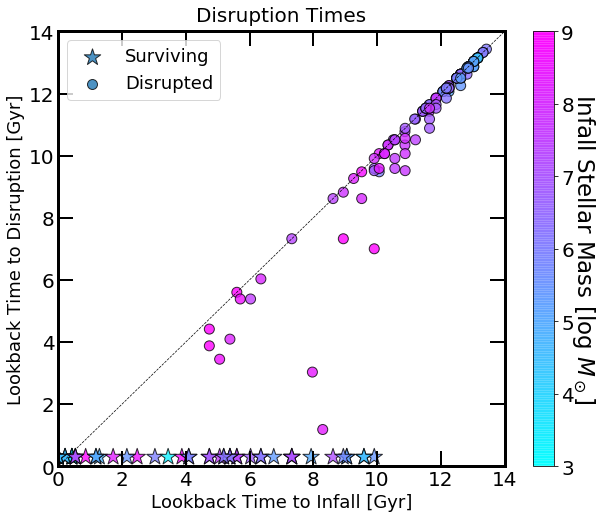

In [6]:
# Color by stellar mass at infall
fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(10, 8))
fig.set_facecolor('w')
# fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 14, 100)
cm = plt.cm.get_cmap('cool')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
x=lookback_t_infall
y=lookback_t_final
z=log_Mstar_infall
# Survivors
im1 = ax1.scatter(x[status=='Survivor'], y[status=='Survivor']+0.3, marker='*', edgecolor='k', c=z[status=='Survivor'], alpha=0.8, lw=1, s=300, cmap=cm, vmin=3, vmax=9, label='Surviving') 
ax1.scatter(x[status=='Zombie'], y[status=='Zombie'], marker='.', edgecolor='black', c=z[status=='Zombie'], alpha=0.8, lw=1, s=400, cmap=cm, vmin=3, vmax=9, label='Disrupted') 
ax1.plot(linx, linx, lw=0.7, c='black', ls='--')

cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('Infall Stellar Mass [log $M_\odot$]', rotation=270, fontsize=23, labelpad=23)
cbar1.ax.tick_params(labelsize=20)

ax1.set_xlim(0, 14)
ax1.set_ylim(0, 14)
ax1.legend(loc='upper left', fontsize=18, frameon=True)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Disruption Times', fontsize=20, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=18)
ax1.set_ylabel('Lookback Time to Disruption [Gyr]', fontsize=18)

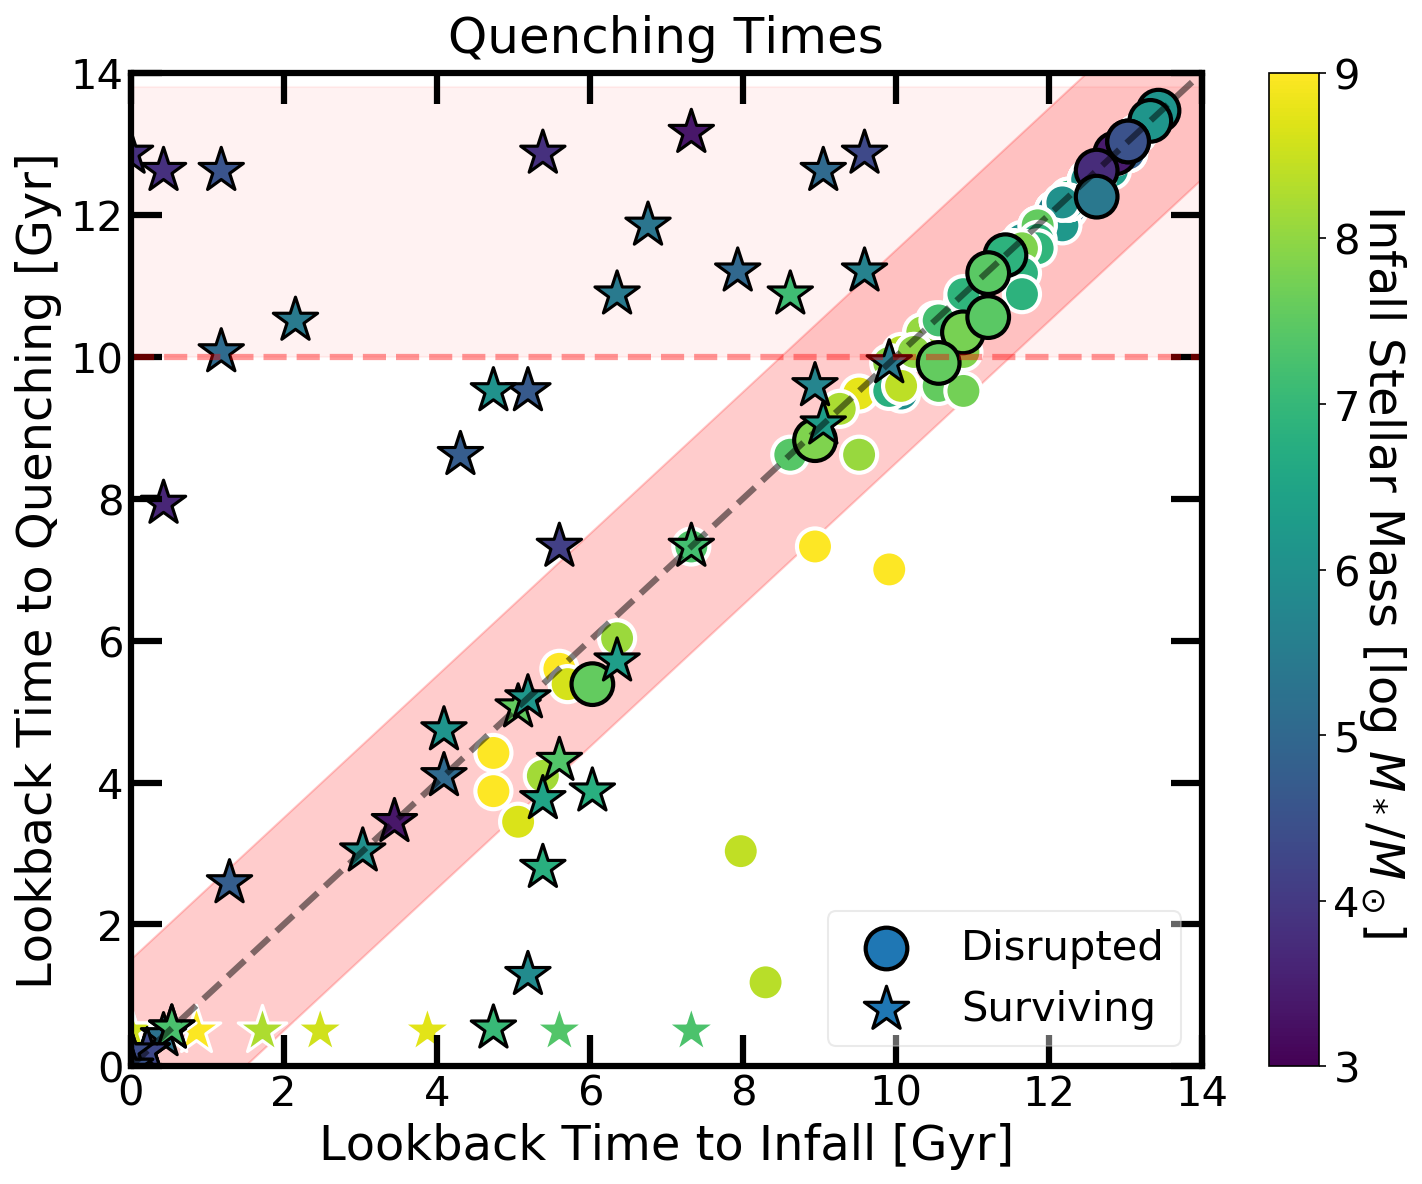

In [65]:
fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(10, 8))
# (ax1, ax2) = ax
fig.set_facecolor('w')
fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 14, 100)
cm = plt.cm.get_cmap('viridis')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)

x=lookback_t_infall
y=lookback_t_quench
k=lookback_t_final
z=log_Mstar_infall
ax1.plot(linx, linx, lw=3, alpha=0.5, c='black', ls='--')
ax1.plot(linx, [10]*len(linx), lw=3, alpha=0.4, c='red', ls='--')
ax1.fill_between(linx, [10]*len(linx), [13.8]*len(linx), color='red', alpha=0.05)
ax1.fill_between(linx, linx-1.5, linx+1.5, color='red', alpha=0.2)

# Zombies
ax1.scatter(x[(status=='Zombie') & (y>13.8)], k[(status=='Zombie') & (y>13.8)], marker='o', 
            edgecolor='w', c=z[(status=='Zombie') & (y>13.8)], lw=2, s=300, cmap=cm, vmin=3, vmax=9) 
ax1.scatter(x[(status=='Zombie') & (y<13.8)], y[(status=='Zombie') & (y<13.8)], marker='o', 
            edgecolor='k', c=z[(status=='Zombie') & (y<13.8)], lw=2, s=400, cmap=cm, vmin=3, vmax=9, 
            label='Disrupted')
# Survivors
im1 = ax1.scatter(x[(status=='Survivor') & (y>13.8)], k[(status=='Survivor') & (y>13.8)]+0.5, marker='*', edgecolor='w',
                  c=z[(status=='Survivor') & (y>13.8)], lw=1.5, s=600, cmap=cm, vmin=3, vmax=9)
im1 = ax1.scatter(x[status=='Survivor'], y[status=='Survivor'], marker='*', edgecolor='k', 
                  c=z[status=='Survivor'], lw=1.5, s=500, cmap=cm, vmin=3, vmax=9, 
                  label='Surviving') 
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('Infall Stellar Mass [log $M_*/M_\odot$]', rotation=270, fontsize=23, labelpad=23)
cbar1.ax.tick_params(labelsize=20)
ax1.set_xlim(0, 14)
ax1.set_ylim(0, 14)
ax1.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.4)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Quenching Times', fontsize=24, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax1.set_ylabel('Lookback Time to Quenching [Gyr]', fontsize=23)
'''
x=lookback_t_infall
y=lookback_t_final
z=log_Mstar_infall
# Survivors
ax2.plot(linx, linx, lw=3, alpha=0.5, c='black', ls='--')
im2 = ax2.scatter(x[status=='Survivor'], y[status=='Survivor']+0.5, marker='|', c=z[status=='Survivor'], lw=6, s=500, cmap=cm, vmin=3, vmax=9, label='Surviving') 
ax2.scatter(x[status=='Zombie'], y[status=='Zombie'], marker='.', edgecolor='k', c=z[status=='Zombie'], lw=1, s=500, cmap=cm, vmin=3, vmax=9, label='Disrupted') 
cbar1 = fig.colorbar(im2, ax=ax2)
cbar1.set_label('Infall Stellar Mass [log $M_\odot$]', rotation=270, fontsize=23, labelpad=23)
cbar1.ax.tick_params(labelsize=23)
ax2.set_xlim(0, 14)
ax2.set_ylim(0, 14)
ax2.legend(loc='upper left', fontsize=23, frameon=True)
ax2.tick_params(which='major', length=15, width=3, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('Disruption Times', fontsize=24, pad=10)
ax2.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax2.set_ylabel('Lookback Time to Disruption [Gyr]', fontsize=23)
'''
fig.tight_layout()

In [13]:
def max_mass_time(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, category='stars', resolution=1000):
    '''
    input params: 
        simulation: h148, h229, h242, h329: string
        status: 'Zombie', 'Survivor': string
        tangos_halo: 0 or a valid Tangos halo object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
        category: 'stars' or 'dm' or 'total': string
    output params:
        maximum stellar mass: the maximum stellar mass of a dwarf before disruption
            [units: Msol]
        time of maximum stellar mass: the earliest time before disruption when a dwarf reaches its maximum stellar mass
            [units: Gyr since start of simulation]
    '''
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    #Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096', resolution=resolution)
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostMstar = fh['M_star_|_Msol'][:]
        hostMvir = fh['Mvir_|_Msol'][:]
        hostMgas = fh['M_gas_|_Msol'][:]
    #Satellite
    path = get_file_path(tangos_halo=tangos_halo, simulation=simulation, status=status, halo_id=halo_id, snap_num=snap_num, resolution=resolution)
    with h5py.File(path, 'r') as f:
        satMstar = f['M_star_|_Msol'][:]
        satMvir = f['Mvir_|_Msol'][:]
        satMgas = f['M_gas_|_Msol'][:]
    total_mass=satMstar+satMvir+satMgas    
    
    if category=='stars':
        max_satM = max(satMstar[satMstar != hostMstar])
        max_satM_time = min(t_Gyr[satMstar==max_satM])
    elif category=='dm':
        max_satM = max(satMvir[satMvir != hostMvir])
        max_satM_time = min(t_Gyr[satMvir==max_satM])
    elif category=='total':
        max_satM = max(total_mass[satMstar != hostMstar])
        max_satM_time = min(t_Gyr[total_mass==max_satM])
    elif category=='ratio':
        ratio = satMstar/total_mass
        ratio[total_mass==0]=0
        max_satM = max(ratio[satMstar != hostMstar])
        max_satM_time = min(t_Gyr[ratio==max_satM])
    else:
        raise ValueError('A very specific bad thing happened. Try category= "stars" or "dm".') 
    
    return max_satM, max_satM_time
np.array([max_mass_time(ID=idx, category='ratio', resolution=100)[0] for idx in ids])

/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


array([1.05616208e-02, 1.13372570e-04, 2.33511647e-03, 1.13135420e-02,
       1.32111814e-02, 1.39760323e-03, 7.71306924e-04, 1.95007399e-02,
       8.14611668e-02, 9.37584927e-03, 1.85834094e-02, 2.52094554e-02,
       5.86481307e-03, 2.53357481e-02, 3.08912728e-02, 8.63862942e-05,
       4.79718070e-05, 1.78479344e-04, 6.81858046e-03, 1.17360233e-02,
       2.05366109e-03, 5.27897496e-06, 1.72651808e-03, 1.33138367e-03,
       2.84390764e-02, 7.46861336e-05, 7.78729359e-05, 5.65763086e-04,
       6.47913306e-05, 1.02878691e-03, 8.76966862e-05, 1.09348449e-03,
       2.62618609e-03, 6.15850971e-04, 3.91700023e-03, 3.40300606e-04,
       1.51987416e-04, 2.82681086e-03, 1.41281253e-04, 9.00192098e-04,
       2.88581137e-02, 8.06161971e-03, 1.26458890e-03, 4.23272235e-03,
       1.06860632e-03, 7.40606664e-04, 5.95059617e-04, 2.10794649e-02,
       9.72995664e-03, 1.45815079e-02, 4.97285560e-03, 4.89920534e-03,
       3.27621343e-03, 4.04488010e-03, 2.00284179e-02, 2.34822024e-03,
      

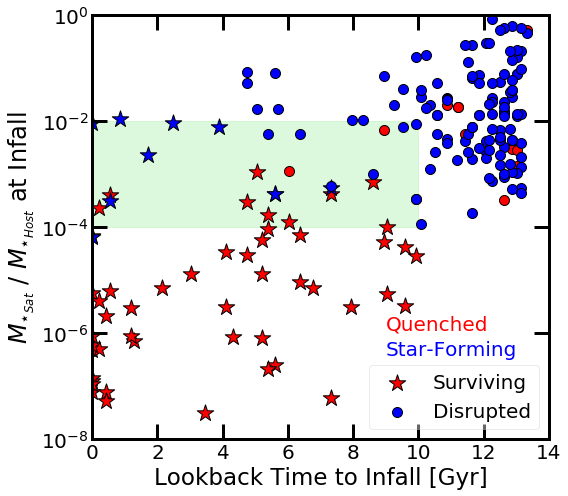

In [59]:
fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(8, 7))
# (ax1, ax2) = ax
fig.set_facecolor('w')
# fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 10, 100)
cm = plt.cm.get_cmap('viridis')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)
# fig.set_dpi(150)
x = lookback_t_infall
y = data['infall_mass_ratio'].to_numpy()

ax1.fill_between(linx, [1e-2]*len(linx), [1e-4]*len(linx), alpha=0.3, color='lightgreen')
# the scatter plot:
ax1.scatter(x[(status=='Survivor')&(t_quench>=0)], y[(status=='Survivor')&(t_quench>=0)], s=300, 
                   color='red', marker='*', edgecolors="black", linewidth=1, alpha=1, label = 'Surviving')
ax1.scatter(x[(status=='Survivor')&(t_quench<0)], y[(status=='Survivor')&(t_quench<0)], s=300,  
                   color='blue', marker='*', edgecolors="black", linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench>=0)], y[(status=='Zombie')&(t_quench>=0)], s=100, 
                   color='red', edgecolors='black', facecolors='red', linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench<0)], y[(status=='Zombie')&(t_quench<0)], s=100, 
                   color='blue', edgecolors='black', facecolors='blue', linewidth=1, alpha=1, label = 'Disrupted')
ax1.text(9, 1.5e-6, 'Quenched', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='red')
ax1.text(9, 0.5e-6, 'Star-Forming', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='blue')
ax1.set_xlim(0, 14)
ax1.set_ylim(1e-8 , 1e0)
ax1.set_yscale('log')
ax1.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.4)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
# ax1.set_title('Quenching Times', fontsize=24, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax1.set_ylabel('$M_{\star_{Sat}}$ / $M_{\star_{Host}}$ at Infall', fontsize=24)

fig.tight_layout()

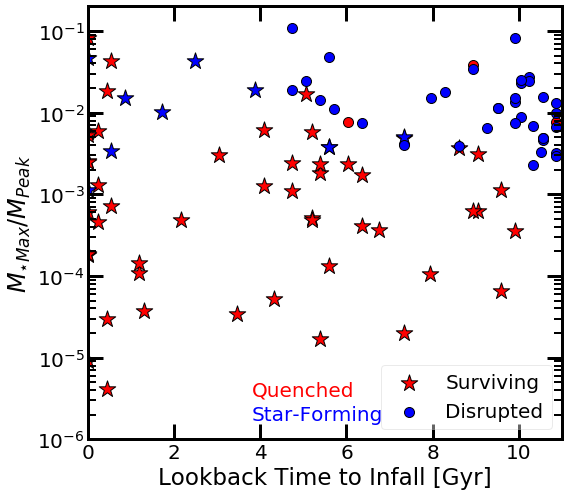

In [34]:
#Ferah's figure

fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(8, 7))
# (ax1, ax2) = ax
fig.set_facecolor('w')
# fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 14, 100)
cm = plt.cm.get_cmap('viridis')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)

Mpeak=np.array([max_mass_time(ID=idx, category='total', resolution=100)[0] for idx in ids])
x = lookback_t_infall
y = (max_Mstar/Mpeak)

# the scatter plot:
ax1.scatter(x[(status=='Survivor')&(t_quench>=0)&(x<11)], y[(status=='Survivor')&(t_quench>=0)&(x<11)], s=300, 
                   color='red', marker='*', edgecolors="black", linewidth=1, alpha=1, label = 'Surviving')
ax1.scatter(x[(status=='Survivor')&(t_quench<0)&(x<11)], y[(status=='Survivor')&(t_quench<0)&(x<11)], s=300,  
                   color='blue', marker='*', edgecolors="black", linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench>=0)&(x<11)], y[(status=='Zombie')&(t_quench>=0)&(x<11)], s=100, 
                   color='red', edgecolors='black', facecolors='red', linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench<0)&(x<11)], y[(status=='Zombie')&(t_quench<0)&(x<11)], s=100, 
                   color='blue', edgecolors='black', facecolors='blue', linewidth=1, alpha=1, label = 'Disrupted')
ax1.text(3.8, 4e-6, 'Quenched', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='red')
ax1.text(3.8, 2e-6, 'Star-Forming', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='blue')
ax1.set_xlim(0, 11)
ax1.set_ylim(1e-6 , 2e-1)
ax1.set_yscale('log')
ax1.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.4)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
# ax1.set_title('Quenching Times', fontsize=24, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax1.set_ylabel('$M_{\star Max}/M_{Peak}$', fontsize=24)

fig.tight_layout()

/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10


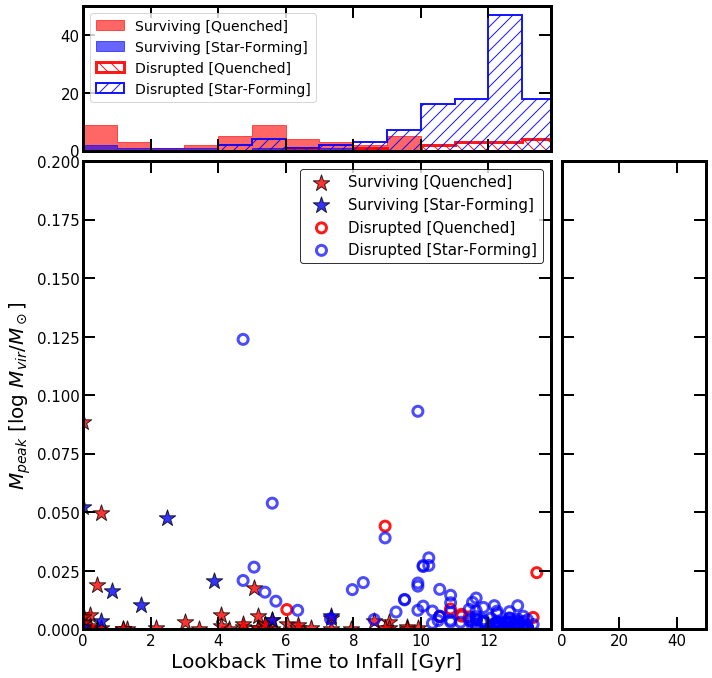

In [10]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.015
Mpeak=np.array([max_mass_time(ID=idx, category='dm', resolution=100)[0] for idx in ids])
x = lookback_t_infall
y = max_Mstar/Mpeak
# y = log_max_Mstar


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
f = plt.figure(figsize=(10, 10))
f.set_facecolor('w')
# f.set_dpi(150)

#axes and ticks
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', which='both', width=2, length=12, labelsize=15, bottom=True, top=True, left=True, right=True)

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', which='both', width=2, length=12, labelsize=15, bottom=True, top=True, left=True, right=True, labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', which='both', width=2, length=12, labelsize=15, bottom=True, top=True, left=True, right=True, labelleft=False)


plt.setp(ax_scatter.spines.values(), linewidth=3)
plt.setp(ax_histx.spines.values(), linewidth=3)
plt.setp(ax_histy.spines.values(), linewidth=3)
# now determine nice limits by hand:
binwidth = 0.5
ax_scatter.set_xlim(0, 13.85)
ax_scatter.set_ylim(0, 0.2)

x_bins = np.arange(0, 13.85+binwidth*2, binwidth*2) #np.linspace, #np.logspace
y_bins = np.arange(3, 12+binwidth, binwidth)

# the scatter plot:
ax_scatter.scatter(x[(status=='Survivor')&(t_quench>=0)], y[(status=='Survivor')&(t_quench>=0)], s=300, 
                   color='red', marker='*', edgecolors="black", linewidth=1, alpha=0.8, label = 'Surviving [Quenched]')
ax_scatter.scatter(x[(status=='Survivor')&(t_quench<0)], y[(status=='Survivor')&(t_quench<0)], s=300,  
                   color='blue', marker='*', edgecolors="black", linewidth=1, alpha=0.8, label = 'Surviving [Star-Forming]')
ax_scatter.scatter(x[(status=='Zombie')&(t_quench>=0)], y[(status=='Zombie')&(t_quench>=0)], s=100, 
                   color='red', edgecolors='red', facecolors='none', linewidth=3, alpha=0.9, label = 'Disrupted [Quenched]')
ax_scatter.scatter(x[(status=='Zombie')&(t_quench<0)], y[(status=='Zombie')&(t_quench<0)], s=100, 
                   color='blue', edgecolors='blue', facecolors='none', linewidth=3, alpha=0.7, label = 'Disrupted [Star-Forming]')
ax_scatter.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=20)
ax_scatter.set_ylabel('$M_{peak}$ [log $M_{vir}/M_\odot$]', fontsize=20)
ax_scatter.legend(loc='upper right', fontsize=15, frameon=True, edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 0.1))



#fill color
ax_histx.hist(x[(status=='Survivor')&(t_quench>=0)], bins=x_bins, histtype = 'step', fill=True, facecolor='red', edgecolor='red', alpha=0.6, label='Surviving [Quenched]')
ax_histx.hist(x[(status=='Survivor')&(t_quench<0)], bins=x_bins, histtype = 'step', fill=True, facecolor='blue', edgecolor='blue', alpha=0.6, label='Surviving [Star-Forming]')
ax_histx.hist(x[(status=='Zombie')&(t_quench>=0)], bins=x_bins, histtype = 'step', fill=False, hatch='\\\\', facecolor='red', edgecolor='red', lw=3, alpha=0.9, label='Disrupted [Quenched]')
ax_histx.hist(x[(status=='Zombie')&(t_quench<0)], bins=x_bins, histtype = 'step', fill=False, hatch='//', facecolor='blue', edgecolor='blue', lw=2, alpha=0.9, label='Disrupted [Star-Forming]')
ax_histx.legend(loc='upper left', fontsize=14, frameon=True)

#fill color
ax_histy.hist(y[(status=='Survivor')&(t_quench>=0)], bins=y_bins, histtype = 'step', fill=True, facecolor='red', edgecolor='red', alpha=0.6, orientation='horizontal')
ax_histy.hist(y[(status=='Survivor')&(t_quench<0)], bins=y_bins, histtype = 'step', fill=True, facecolor='blue', edgecolor='blue', alpha=0.6, orientation='horizontal')
ax_histy.hist(y[(status=='Zombie')&(t_quench>=0)], bins=y_bins, histtype = 'step', fill=False, hatch='\\\\', facecolor='red', edgecolor='red', lw=3, alpha=0.9, orientation='horizontal')
ax_histy.hist(y[(status=='Zombie')&(t_quench<0)], bins=y_bins, histtype = 'step', fill=False, hatch='//', facecolor='blue', edgecolor='blue', lw=2, alpha=0.9, orientation='horizontal')


ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

ax_histx.set_ylim(0, 50)
ax_histy.set_xlim(0, 50)

for sim in ['h148', 'h229', 'h242', 'h329']:
    path = get_file_path(tangos_halo=0, simulation=sim, status='Host', halo_id='1', snap_num='4096')
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostMstar = fh['M_star_|_Msol'][:]
    lookback_t = 13.80-t_Gyr
    log_host_Mstar = np.log10(hostMstar)
    ax_scatter.plot(lookback_t, log_host_Mstar, lw=3, color='green', alpha=0.5)

#plt.tight_layout()
plt.show()

In [30]:
def infall_final_coordinates(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0):
    '''
    input params: 
        simulation: h148, h229, h242, h329: string
        status: 'Zombie', 'Survivor': string
        tangos_halo: 0 or a valid Tangos halo object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
    output params:
        [0] coordinates at infall: Relative x, [pkpc]
                                            y, [pkpc]
                                            z, [pkpc]
                                            linear distance, [pkpc]
                                            angle and [radian]
                                            distance away from z axis of satellite CM from host CM [pkpc]
        [1] coordinates at final snapshot: Relative x, [pkpc]
                                                    y, [pkpc]
                                                    z, [pkpc]
                                                    linear distance, [pkpc]
                                                    angle and [radian]
                                                    distance away from z axis of satellite CM from host CM [pkpc]     
    '''  
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    # Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096')
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostMstar = fh['M_star_|_Msol'][:]
        hostx = fh['Xc_|_kpc'][:]
        hosty = fh['Yc_|_kpc'][:]
        hostz = fh['Zc_|_kpc'][:]
    # Satellite
    path = get_file_path(tangos_halo=tangos_halo, simulation=simulation, 
                         status=status, halo_id=halo_id, snap_num=snap_num)
    with h5py.File(path, 'r') as f:
        satMstar = f['M_star_|_Msol'][:]
        satx = f['Xc_|_kpc'][:]
        saty = f['Yc_|_kpc'][:]
        satz = f['Zc_|_kpc'][:]
    t_accretion = accretion_time(ID=ID, simulation=simulation, status=status, 
                                 tangos_halo=tangos_halo, halo_id=halo_id, 
                                 snap_num=snap_num, category='stars')[0]
    # At Infall:
    x_i = (satx-hostx)[t_Gyr == t_accretion][0] #pkpc
    y_i = (saty-hosty)[t_Gyr == t_accretion][0] #pkpc
    z_i = (satz-hostz)[t_Gyr == t_accretion][0] #pkpc
    R_i = np.sqrt(x_i**2 + y_i**2 + z_i**2) #pkpc
    cosPhi_i = z_i/R_i
    Phi_i = np.arccos(cosPhi_i) #Radians
    z_i_away = z_i*np.tan(Phi_i) #pkpc: perpendicular distance away from z-axis
    
    # At final snapshot:
    t_final = max(t_Gyr[hostMstar != satMstar])
    x_f = (satx-hostx)[t_Gyr == t_final][0] #pkpc
    y_f = (saty-hosty)[t_Gyr == t_final][0] #pkpc
    z_f = (satz-hostz)[t_Gyr == t_final][0] #pkpc
    R_f = np.sqrt(x_f**2 + y_f**2 + z_f**2) #pkpc 
    cosPhi_f = z_f/R_f
    Phi_f = np.arccos(cosPhi_f) #Radians
    z_f_away = z_f*np.tan(Phi_f) #pkpc: perpendicular distance away from z-axis
    
    return (x_i, y_i, z_i, R_i, Phi_i, z_i_away), (x_f, y_f, z_f, R_f, Phi_f, z_f_away)

In [15]:
status = data['Status'].to_numpy()
phi_infall = np.array([infall_final_coordinates(ID=idx)[0][4] for idx in ids])
phi_infall_deg = 180*phi_infall/np.pi
phi_infall_deg[phi_infall_deg>90]=180-phi_infall_deg[phi_infall_deg>90]

phi_final = np.array([infall_final_coordinates(ID=idx)[1][4] for idx in ids])
phi_final_deg = 180*phi_final/np.pi
phi_final_deg[phi_final_deg>90]=180-phi_final_deg[phi_final_deg>90]

Mstar_infall = np.array([accretion_time(ID=idx)[1] for idx in ids]) 
log_Mstar_infall = np.log10(Mstar_infall)

t_final = data['time_disruption'].to_numpy()
t_infall = np.array([accretion_time(ID=idx)[0] for idx in ids]) 
max_Mstar = data['max_stellarmass'].to_numpy()
log_max_Mstar = np.log10(max_Mstar)

t_final[t_final==-1]=13.80 # For survivors
Delta_t = t_final - t_infall

OSError: Unable to open file (unable to open file: name = 'Halo_Files/h148/Survivor/snap_4096_halo_1101.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Text(0, 0.5, 'Infall $\\phi_z$ [deg]')

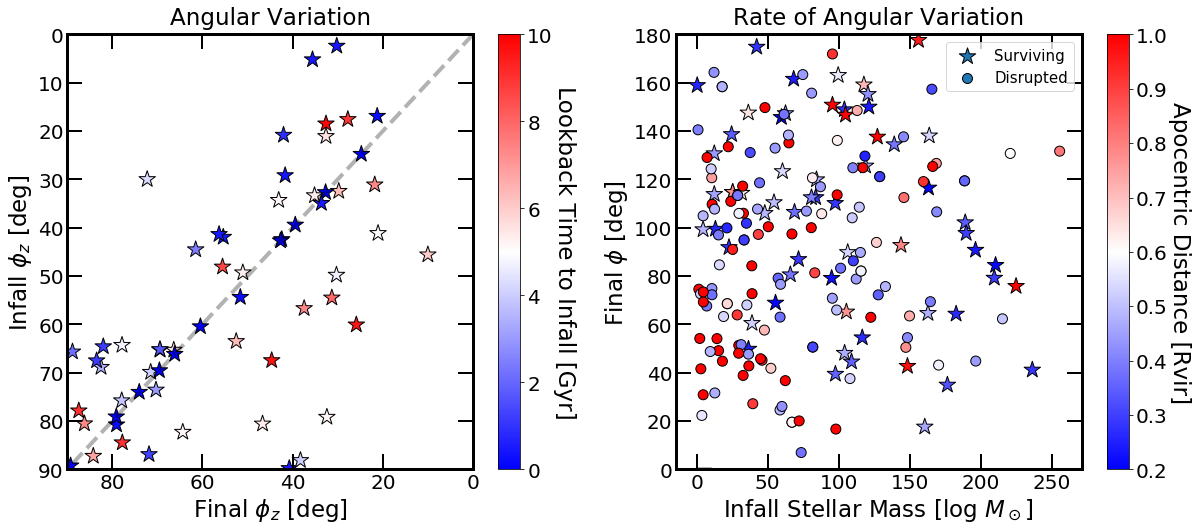

In [28]:
d_closest_hostRvir = data['distance_closest_approach_hostRvir'].to_numpy()
Theta_infall = data['infall_Theta'].to_numpy()
Theta_infall_deg = 180*Theta_infall/np.pi

Phi_infall = data['infall_Phi'].to_numpy()
Phi_infall_deg = 180*Phi_infall/np.pi

vTheta_infall = data['infall_vTheta'].to_numpy()



fig, (ax2, ax1) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(20, 8))
fig.set_facecolor('w')
# fig.set_dpi(150)
np.seterr(divide='ignore')
cm = plt.cm.get_cmap('bwr')
linx=np.linspace(0, 90, 100)
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)

x=vTheta_infall
y=Theta_infall_deg #lookback_t_infall
z=d_closest_hostRvir
linx=np.linspace(0, 14, 100)
# the scatter plot:
ax1.plot(linx, [0]*len(linx), lw=4, alpha=0.3, c='k', ls='--')
im1=ax1.scatter(x[(status=='Survivor') ], y[(status=='Survivor')], s=300, 
                c=z[(status=='Survivor') ], cmap=cm, vmin=0.2, vmax=1,
                marker='*', edgecolors='black', linewidth=1, alpha=1, label = 'Surviving')
ax1.scatter(x[(status=='Zombie') ], y[(status=='Zombie') ], s=100, 
            c=z[(status=='Zombie') ], cmap=cm, vmin=0.2, vmax=1,
            edgecolors='black', linewidth=1, alpha=1, label = 'Disrupted')
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('Apocentric Distance [Rvir]', rotation=270, fontsize=23, labelpad=23)
cbar1.ax.tick_params(labelsize=20)
# ax1.set_xlim(3, 10)
ax1.set_ylim(0, 180)
# ax1.set_xscale('log')
ax1.legend(loc='best', fontsize=15, frameon=True)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Rate of Angular Variation', fontsize=23, pad=10)
ax1.set_xlabel('Infall Stellar Mass [log $M_\odot$]', fontsize=23)
ax1.set_ylabel('Final $\phi$ [deg]', fontsize=23)

cm = plt.cm.get_cmap('bwr')
x=phi_final_deg
y=phi_infall_deg
z=lookback_t_infall
linx=np.linspace(0, 90, 100)
# the scatter plot:
# im1=ax2.scatter(x[(status=='Zombie')], y[(status=='Zombie')], s=100, c=z[status=='Zombie'], cmap=cm, vmin=0, vmax=14,
#             edgecolors='black', facecolors='none', linewidth=1, alpha=1, label = 'Disrupted')
im1=ax2.scatter(x[(status=='Survivor')], y[(status=='Survivor')], s=300, c=z[status=='Survivor'], cmap=cm, vmin=0, vmax=10,
            marker='*', edgecolors="black", linewidth=1, alpha=1, label = 'Surviving')
cbar1 = fig.colorbar(im1, ax=ax2)
ax2.plot(linx, linx, lw=4, alpha=0.3, c='k', ls='--')
cbar1.set_label('Lookback Time to Infall [Gyr]', rotation=270, fontsize=23, labelpad=23)
cbar1.ax.tick_params(labelsize=20)
ax2.set_xlim(90, 0)
ax2.set_ylim(90, 0)
# ax2.legend(loc=(.45, .20), fontsize=15, frameon=True)
ax2.tick_params(which='major', length=15, width=2, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('Angular Variation', fontsize=23, pad=10)
ax2.set_xlabel('Final $\phi_z$ [deg]', fontsize=23)
ax2.set_ylabel('Infall $\phi_z$ [deg]', fontsize=23)

#vs velocities, v_phi

Text(0, 0.5, 'Distance from Host [kpc]')

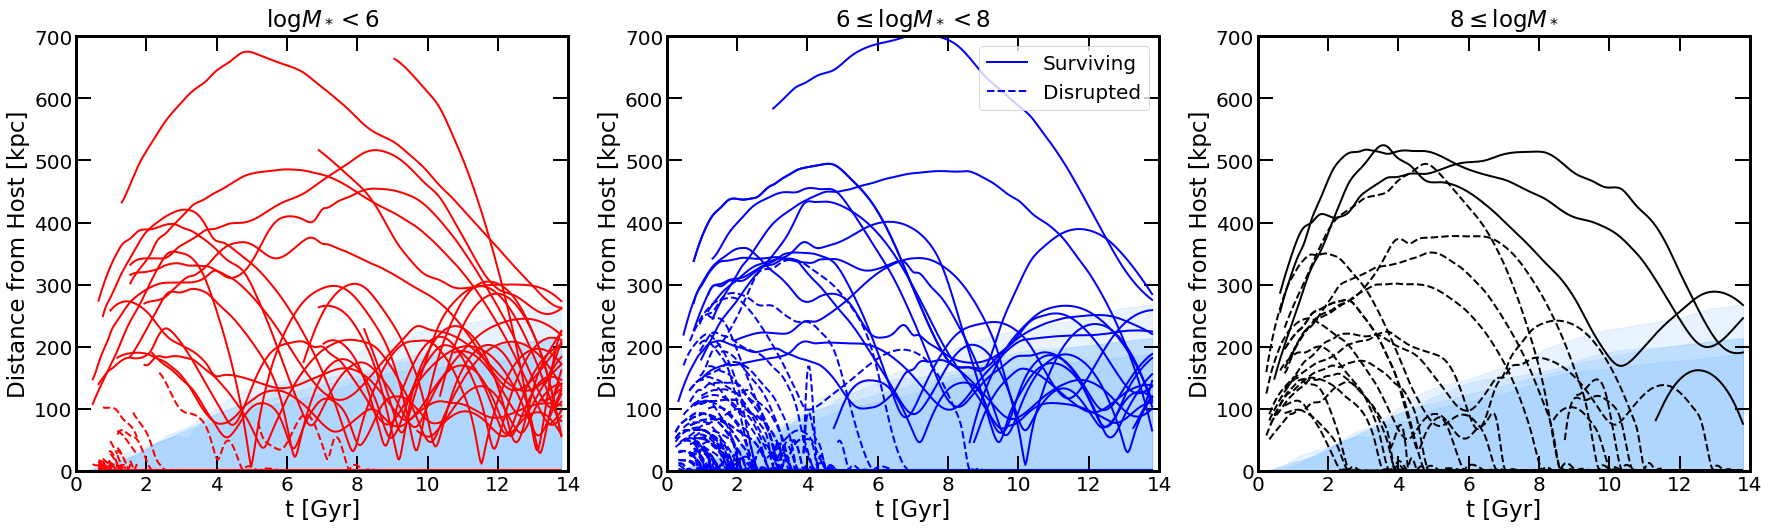

In [14]:
data = pd.read_csv('Data100.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
infall_Mstar = data['infall_mass'].to_numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(30, 8))
fig.set_facecolor('w')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)

for sim in ['h148', 'h229', 'h242', 'h329']:
    path = get_file_path(tangos_halo=0, simulation=sim, status='Host', halo_id='1', snap_num='4096')
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostRvir = fh['Rvir_|_kpc'][:]
    ax1.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax2.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax3.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
count=0    
for idx in ids[(status=='Survivor')]:
    k, (t, x, y, z, Rvir) = orbit_interpolation(ID=idx, resolution=100)
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    R = (x**2 + y**2 + z**2)**(1/2)
    if np.log10(infall_Mstar[ids==idx])<6:
        ax1.plot(t, R, lw=2, alpha=1, c='r')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax2.plot(t, R, lw=2, alpha=1, c='b', label='Surviving')
            count+=1
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='b')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax3.plot(t, R, lw=2, alpha=1, c='k')


count=0
for idz in ids[(status=='Zombie')]:
    k, (t, x, y, z, Rvir) = orbit_interpolation(ID=idz, resolution=100)
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    R = (x**2 + y**2 + z**2)**(1/2)

    if np.log10(infall_Mstar[ids==idz])<6:
        ax1.plot(t, R, lw=2, alpha=1, c='r', ls='--')
    elif np.log10(infall_Mstar[ids==idz])>=6 and np.log10(infall_Mstar[ids==idz])<8:
        if count==0:
            ax2.plot(t, R, lw=2, alpha=1, c='b', ls='--', label='Disrupted')
            count+=1
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='b', ls='--')
    elif np.log10(infall_Mstar[ids==idz])>=8:
        ax3.plot(t, R, lw=2, alpha=1, c='k', ls='--')
        
ax1.set_xlim(0, 14)
ax1.set_ylim(-1, 700)
# ax1.set_xscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('$\log M_* < 6$', fontsize=23, pad=10)
ax1.set_xlabel('t [Gyr]', fontsize=23)
ax1.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax2.set_xlim(0, 14)
ax2.set_ylim(-1, 700)
# ax1.set_xscale('log')
ax2.legend(loc='best', fontsize=20, frameon=True)
ax2.tick_params(which='major', length=15, width=2, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('$6 \leq \log M_* < 8$', fontsize=23, pad=10)
ax2.set_xlabel('t [Gyr]', fontsize=23)
ax2.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax3.set_xlim(0, 14)
ax3.set_ylim(-1, 700)
# ax1.set_xscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax3.tick_params(which='major', length=15, width=2, labelsize=15)
ax3.tick_params(which='minor', length=8, width=2, labelsize=15)
ax3.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax3.set_title('$8 \leq \log M_*$', fontsize=23, pad=10)
ax3.set_xlabel('t [Gyr]', fontsize=23)
ax3.set_ylabel('Distance from Host [kpc]', fontsize=23)

/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: Ru

/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: Ru

Text(0, 0.5, 'Distance from Host [kpc]')

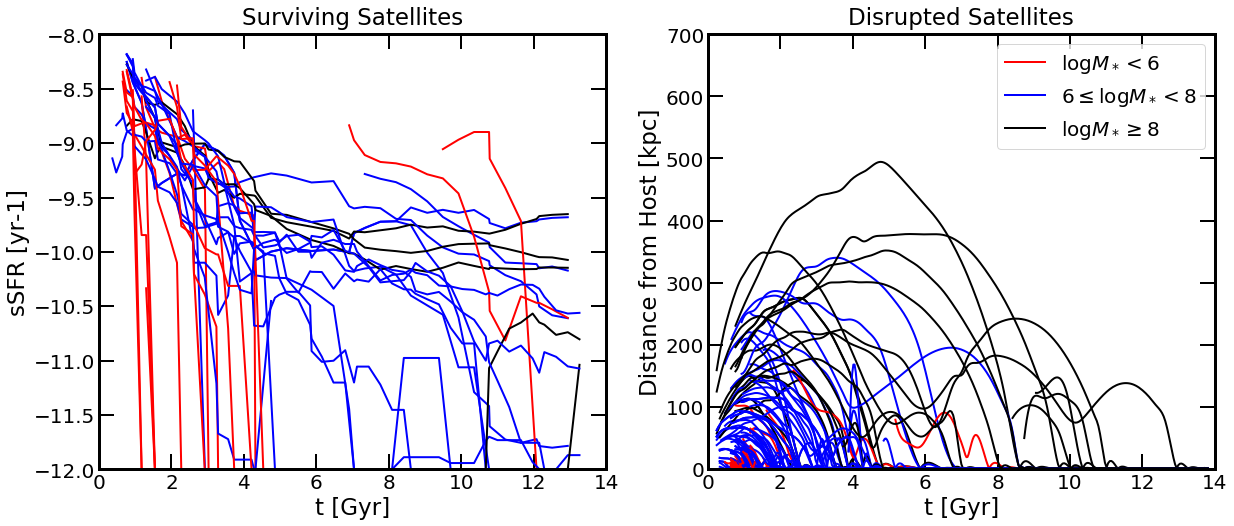

In [22]:
data = pd.read_csv('Data100.csv')
status = data['Status'].to_numpy()
ids = data['IDs'].to_numpy()
infall_Mstar = data['infall_mass'].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(20, 8))
fig.set_facecolor('w')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)

# for sim in ['h148', 'h229', 'h242', 'h329']:
#     path = get_file_path(tangos_halo=0, simulation=sim, status='Host', halo_id='1', snap_num='4096')
#     with h5py.File(path, 'r') as fh:
#         t_Gyr = fh['time_|_Gyr'][:]
#         hostRvir = fh['Rvir_|_kpc'][:]
#     ax1.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
#     ax2.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    
for idx in ids[(status=='Survivor')]:
    t_quench, sSFR, t = quenching_time(ID=idx, resolution=100)
    sSFR[sSFR<1e-12]=1e-12
#     t=np.array(t)
#     x=np.array(x)
#     y=np.array(y)
#     z=np.array(z)
#     R = (x**2 + y**2 + z**2)**(1/2)
    a = np.zeros(len(sSFR))
    for i in range(2, len(sSFR)-2):
        a[i] = np.average([sSFR[i-2], sSFR[i-1], sSFR[i], sSFR[i+1], sSFR[i+2]])
    if np.log10(infall_Mstar[ids==idx])<6:
        ax1.plot(t, np.log10(a), lw=2, alpha=1, c='r')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        ax1.plot(t, np.log10(a), lw=2, alpha=1, c='b')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax1.plot(t, np.log10(a), lw=2, alpha=1, c='k')

ax1.set_xlim(0, 14)
ax1.set_ylim(-12, -8)
# ax1.set_yscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Surviving Satellites', fontsize=23, pad=10)
ax1.set_xlabel('t [Gyr]', fontsize=23)
ax1.set_ylabel('sSFR [yr-1]', fontsize=23)
    
count1=0
count2=0
count3=0
for idz in ids[(status=='Zombie')]:
    k, (t, x, y, z, Rvir) = orbit_interpolation(ID=idz, resolution=100)
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    R = (x**2 + y**2 + z**2)**(1/2)

    if np.log10(infall_Mstar[ids==idz])<6:
        if count1==0:
            ax2.plot(t, R, lw=2, alpha=1, c='r', label='$\log M_* < 6$')
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='r')
        count1+=1
    elif np.log10(infall_Mstar[ids==idz])>=6 and np.log10(infall_Mstar[ids==idz])<8:
        if count2==0:
            ax2.plot(t, R, lw=2, alpha=1, c='b', label='$6 \leq \log M_* < 8$')
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='b')
        count2+=1
    elif np.log10(infall_Mstar[ids==idz])>=8:
        if count3==0:
            ax2.plot(t, R, lw=2, alpha=1, c='k', label='$\log M_* \geq 8$')
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='k')
        count3+=1
ax2.set_xlim(0, 14)
ax2.set_ylim(-1, 700)
# ax1.set_xscale('log')
ax2.legend(loc='best', fontsize=20, frameon=True)
ax2.tick_params(which='major', length=15, width=2, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('Disrupted Satellites', fontsize=23, pad=10)
ax2.set_xlabel('t [Gyr]', fontsize=23)
ax2.set_ylabel('Distance from Host [kpc]', fontsize=23)

In [7]:
halo = ID_to_tangos_halo(ID='1484096306')
print('SFR: ',  halo.calculate_for_progenitors(str('SFR_100Myr'))[0])
print('M_star: ', halo.calculate_for_progenitors(str('M_star'))[0])
print('n_star: ', halo.calculate_for_progenitors(str('n_star'))[0])

SFR:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.40172188e-05
 6.93459202e-05 0.00000000e+00 0.00000000e+00]
M_star:  [ 9986.6   9986.65  9986.7   9986.76  9986.81  9986.82  9986.89  9986.96
  9987.03  9987.04  9987.12  9987.21  9987.31  9987.42  9987.55  9987.68
  9987.83  9988.14  9988.2   9988.43  9988.81 10084.6  10146.9  10152.7
 10219.3  10248.4  10343.2  10409.3  10437.3  10625.9  10716.7  10973.6
 11133.7  11425.7  11646.7  12523.7   

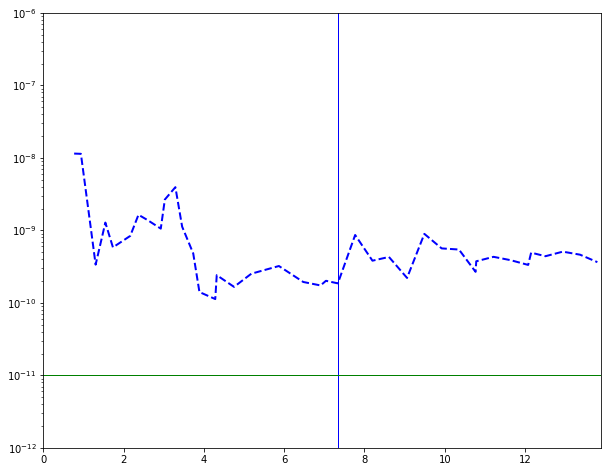

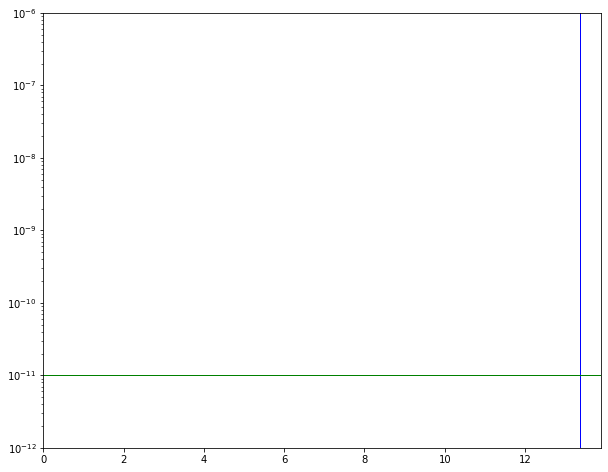

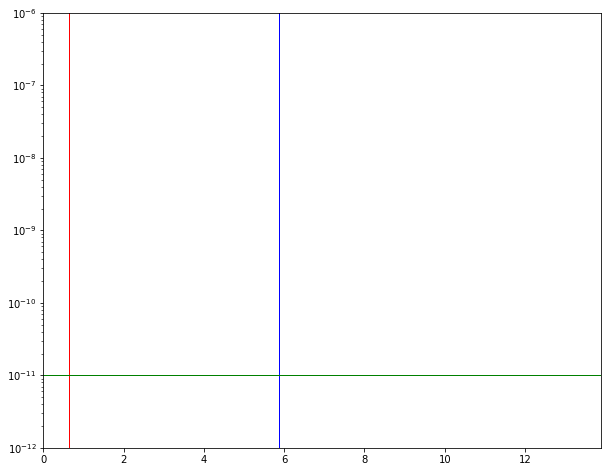

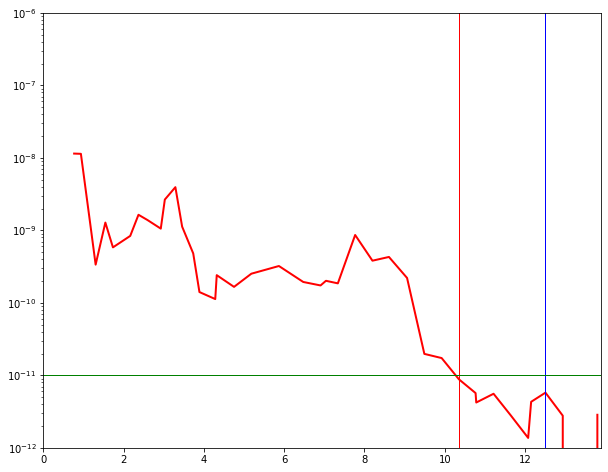

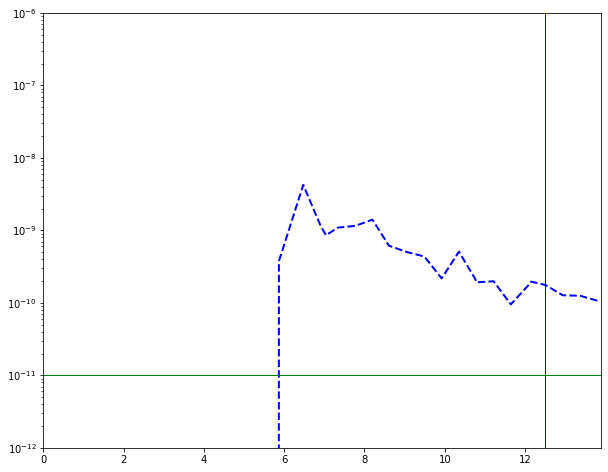

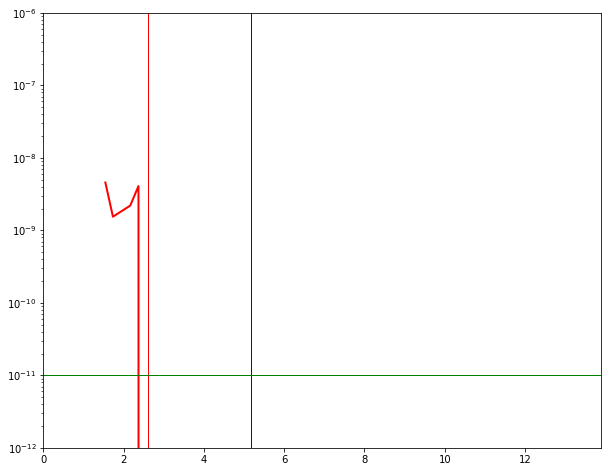

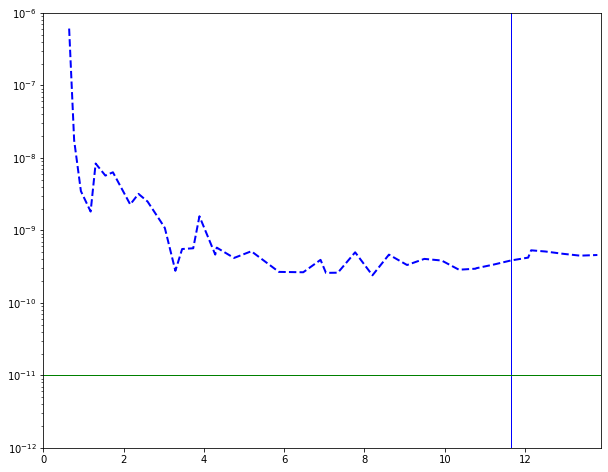

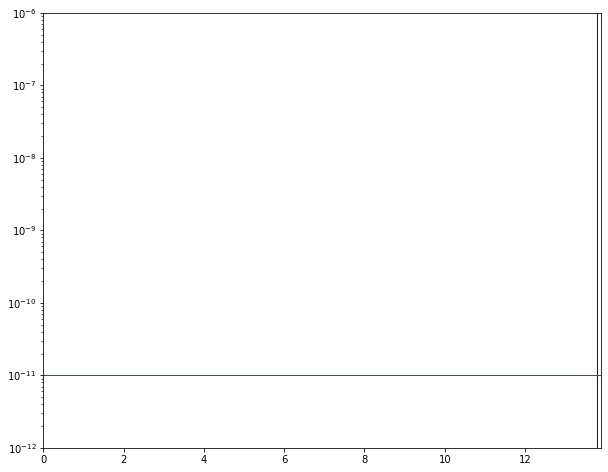

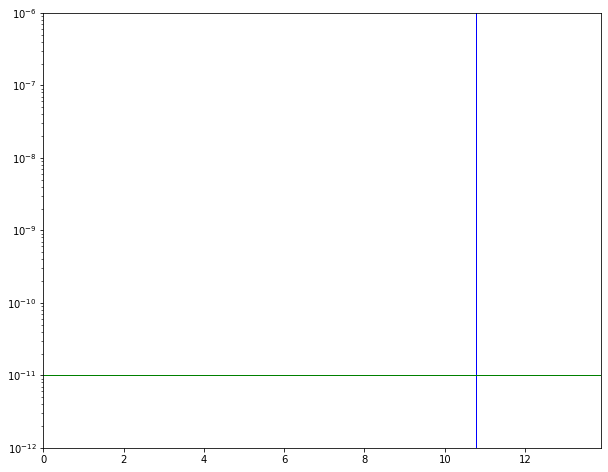

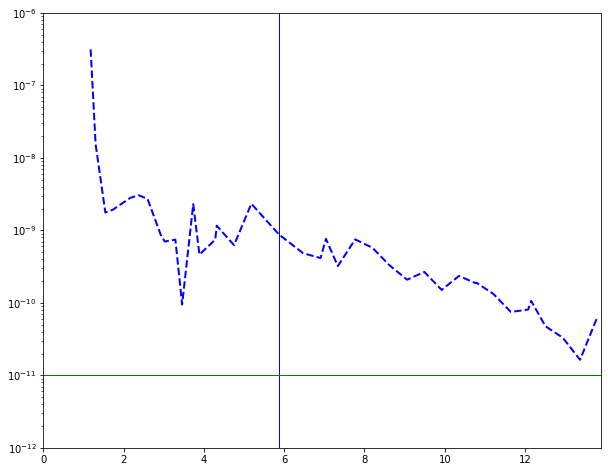

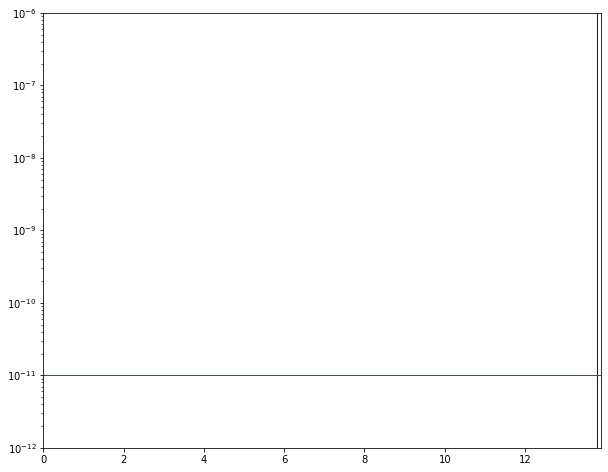

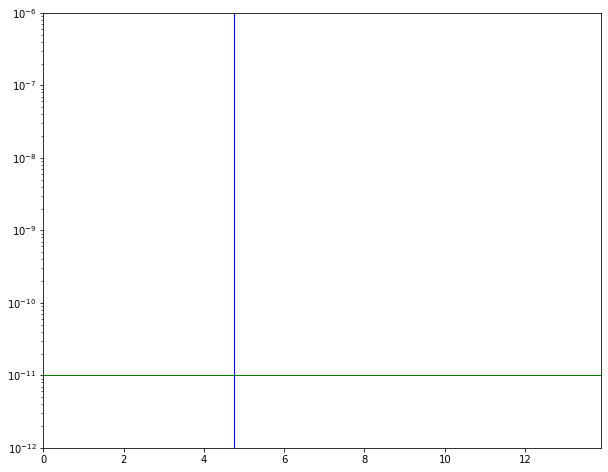

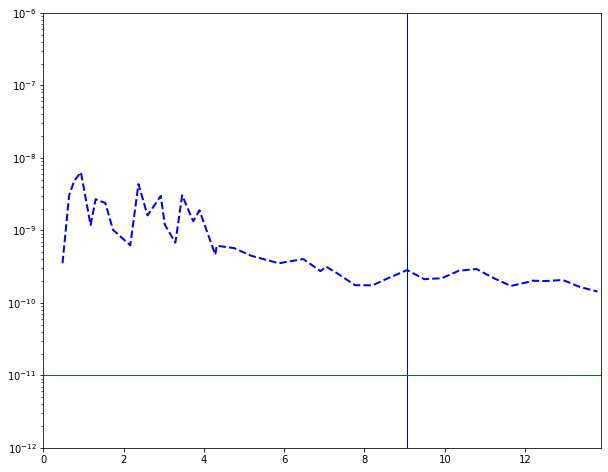

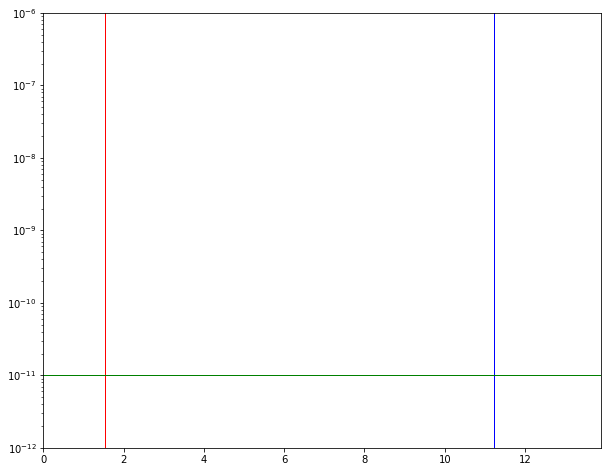

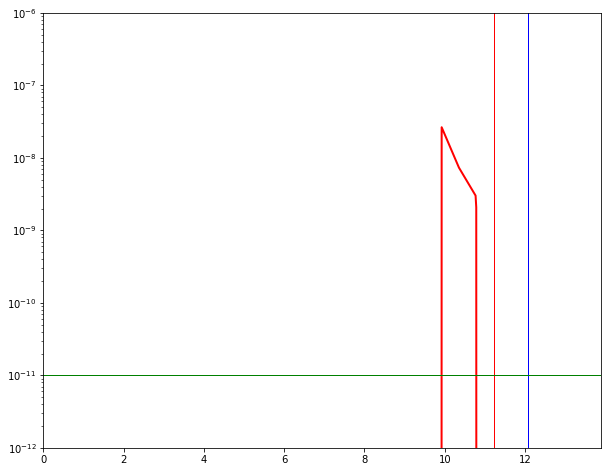

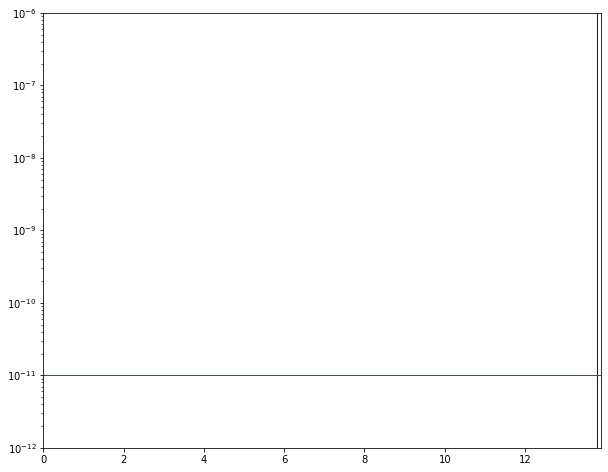

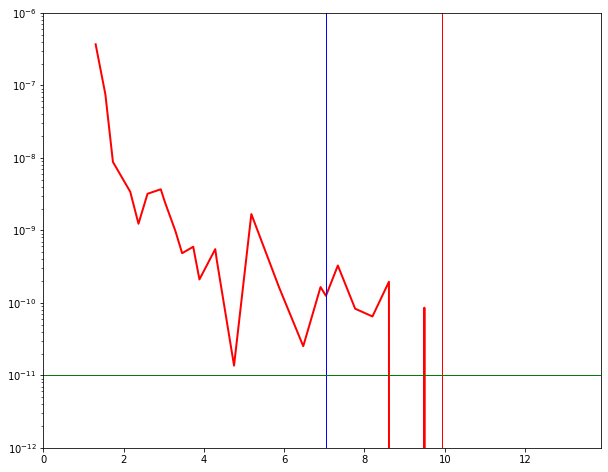

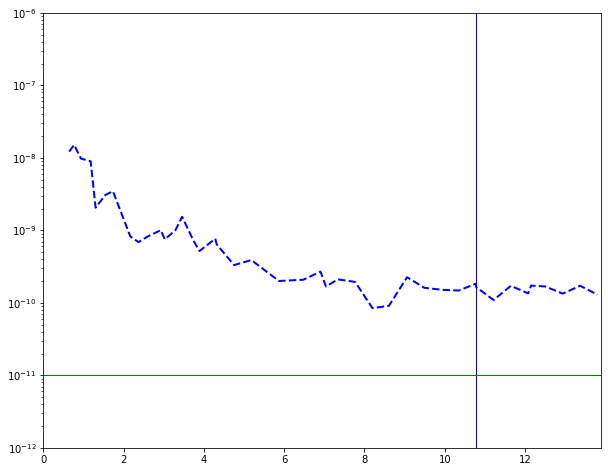

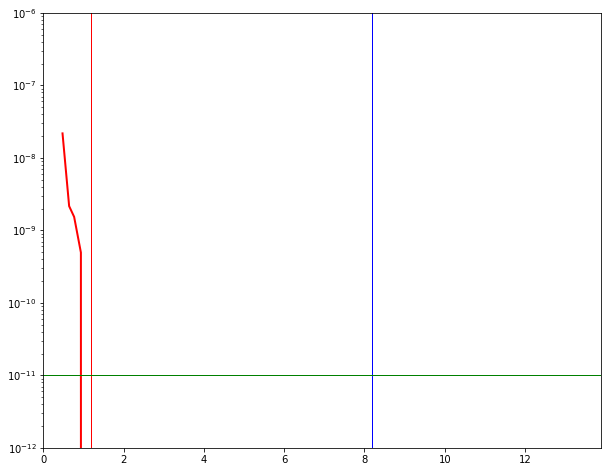

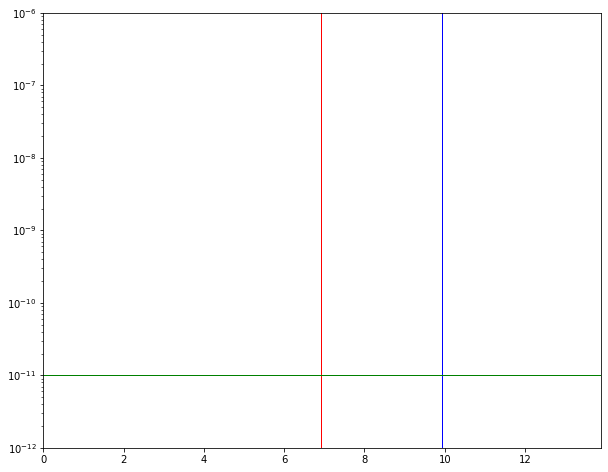

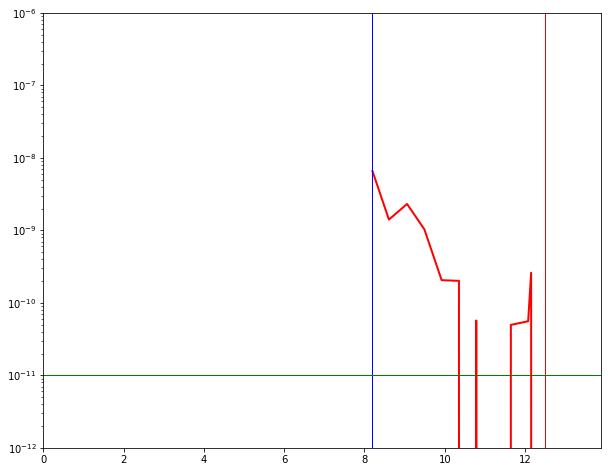

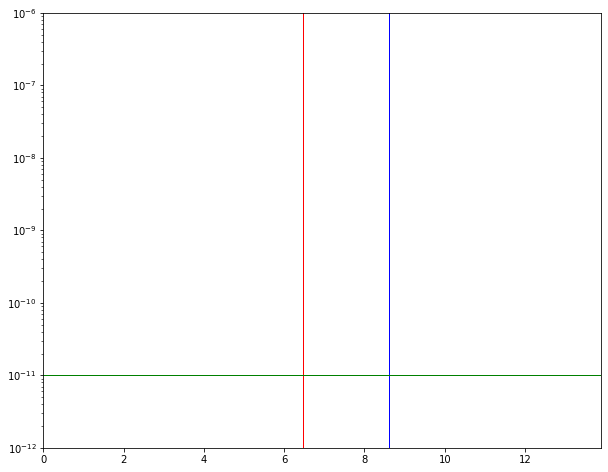

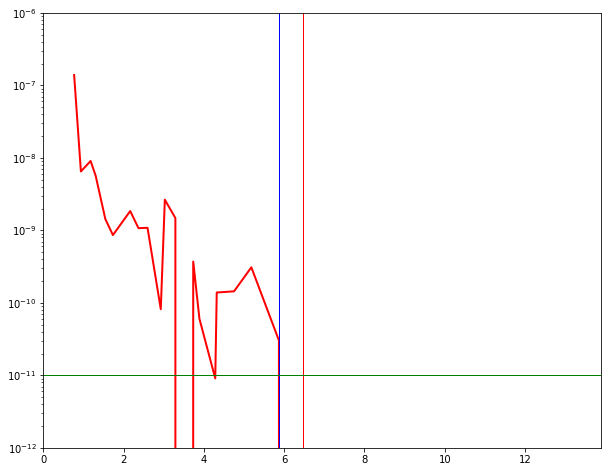

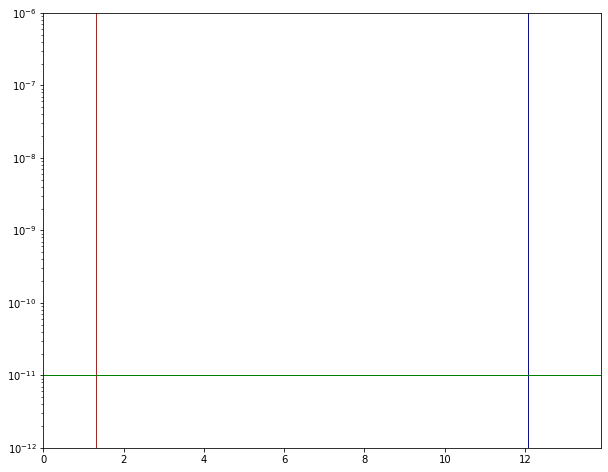

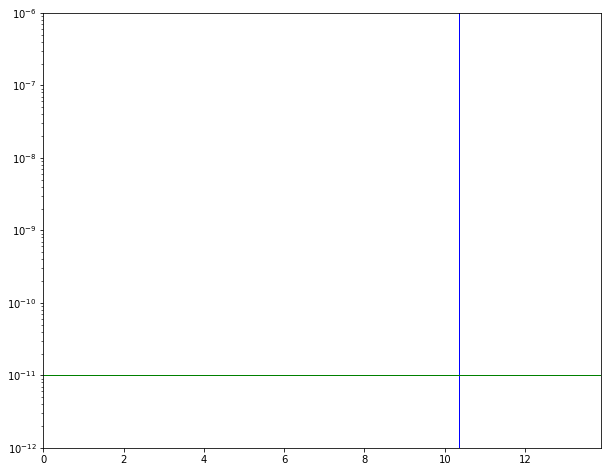

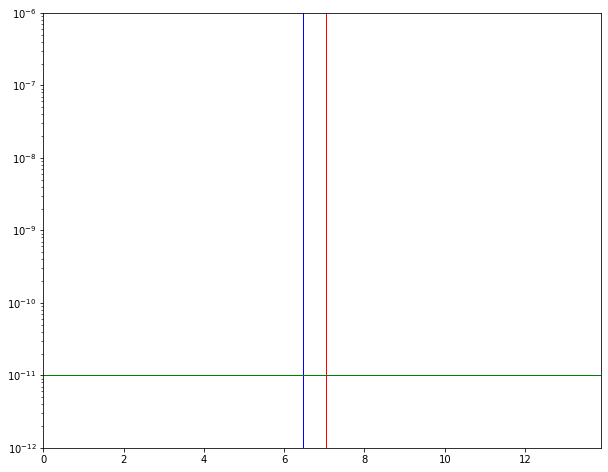

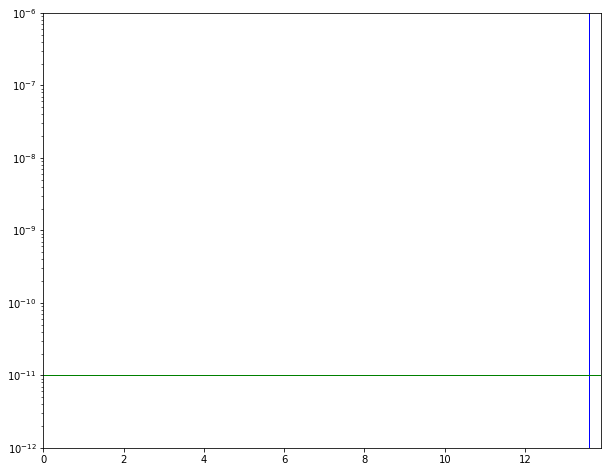

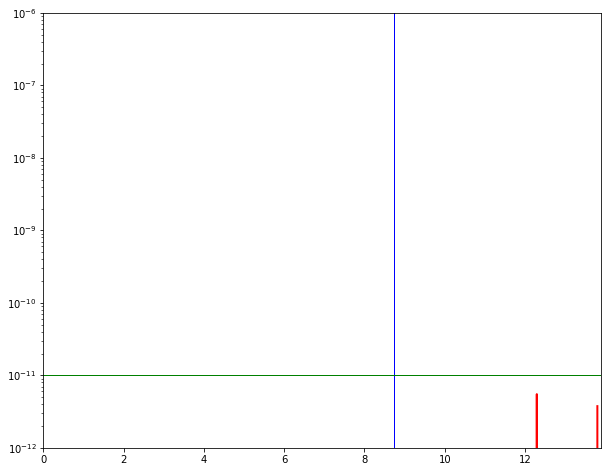

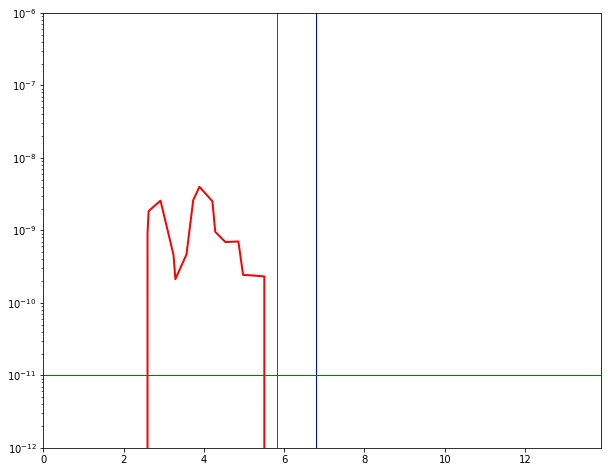

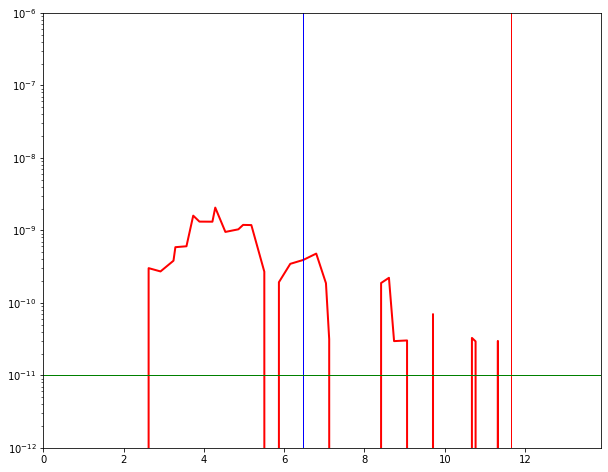

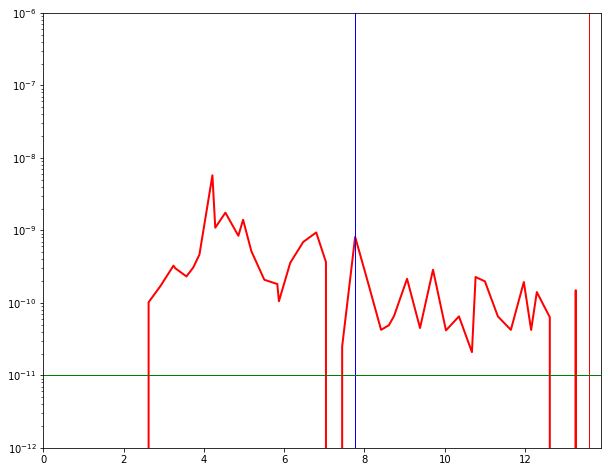

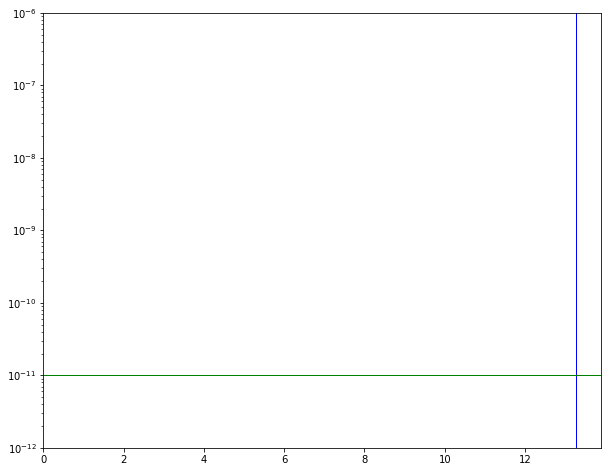

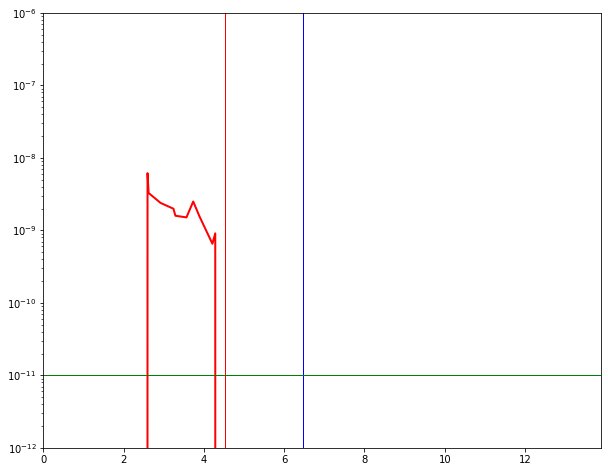

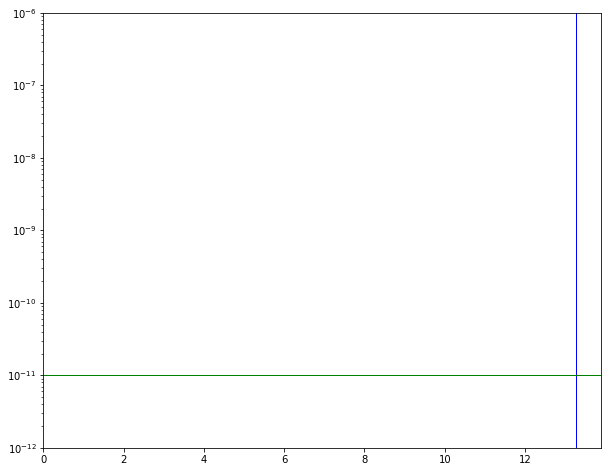

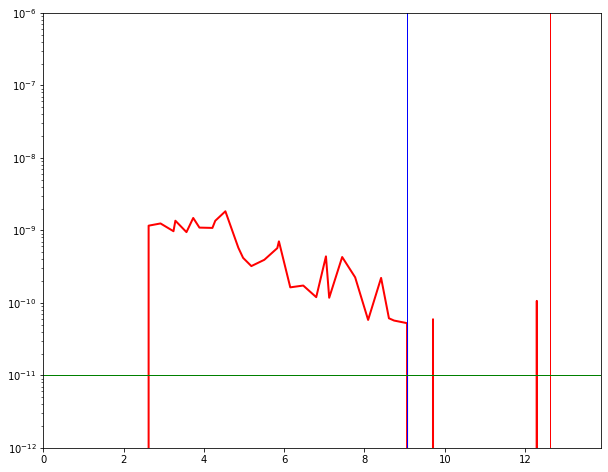

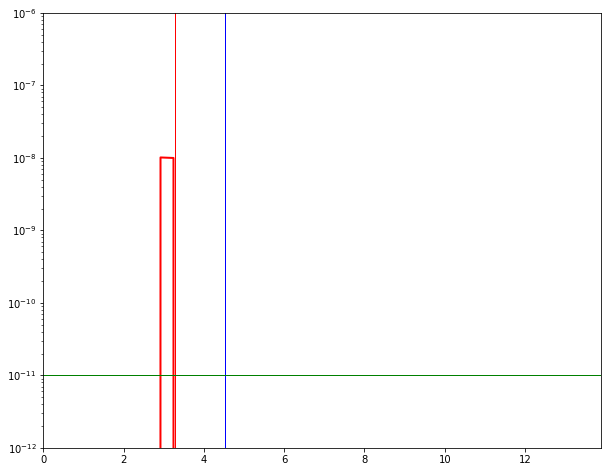

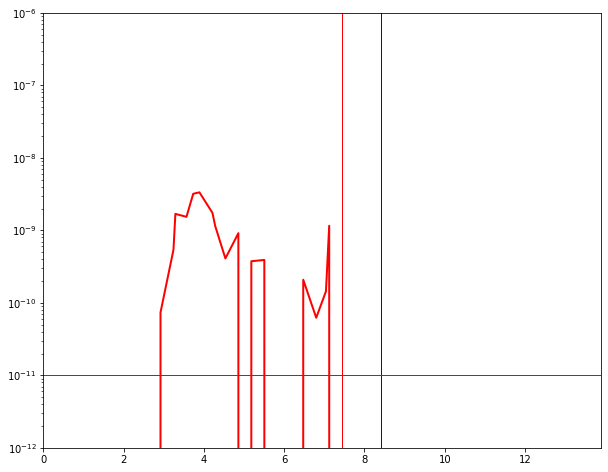

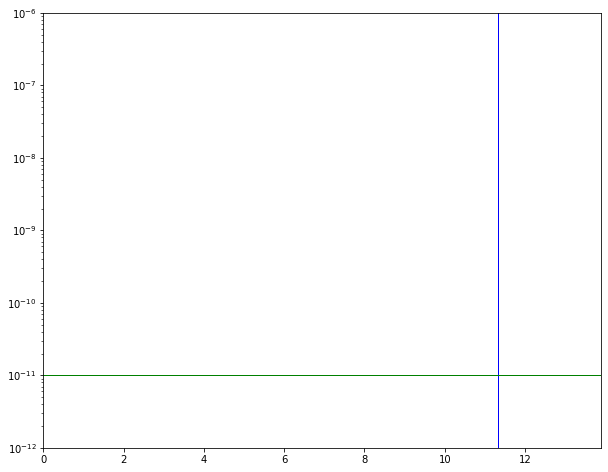

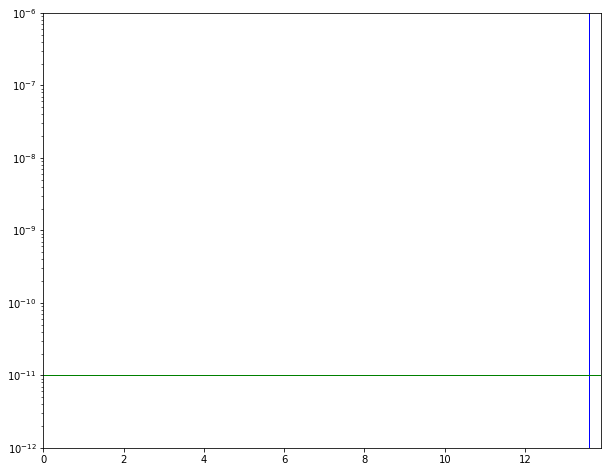

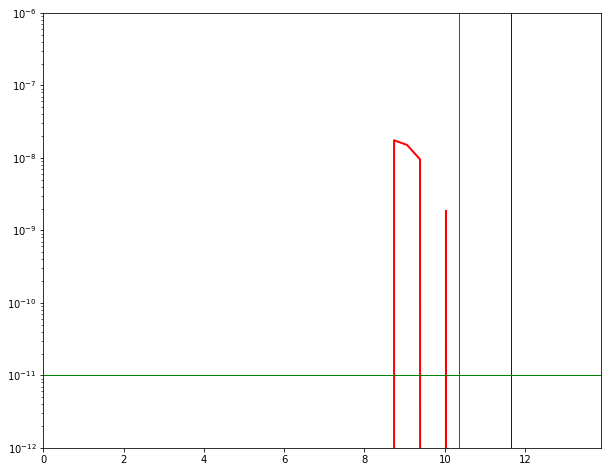

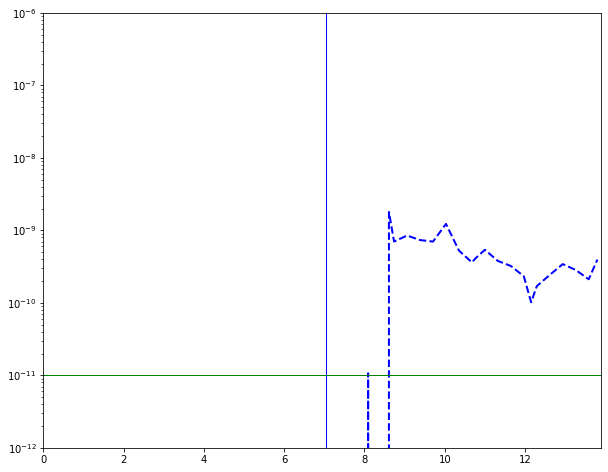

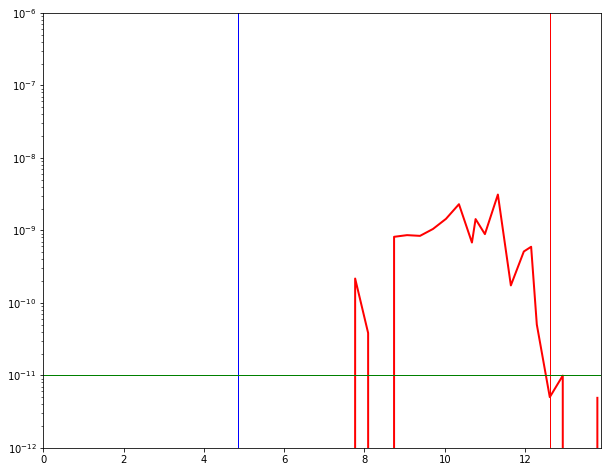

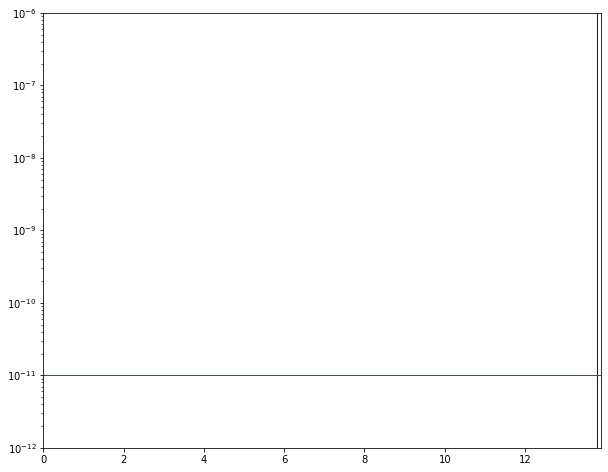

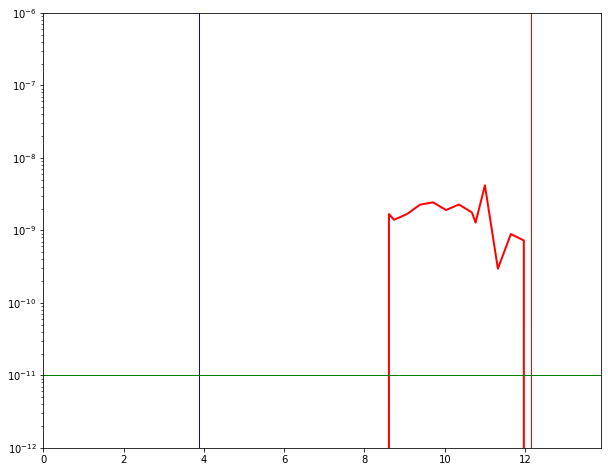

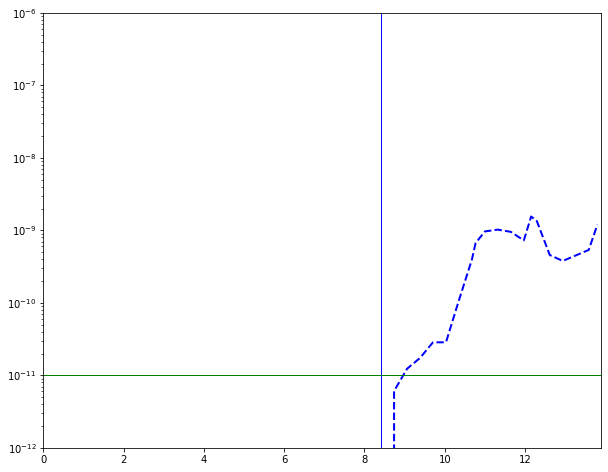

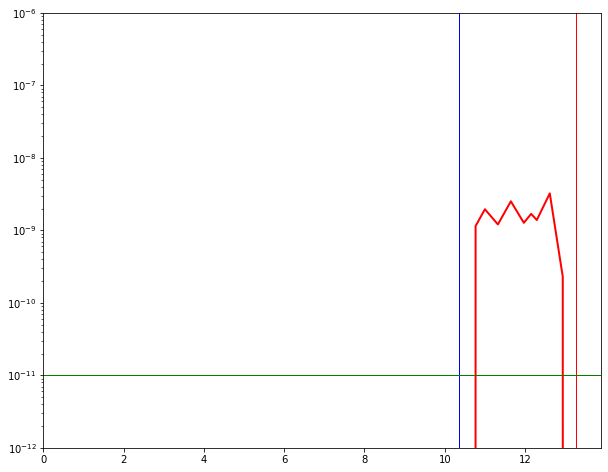

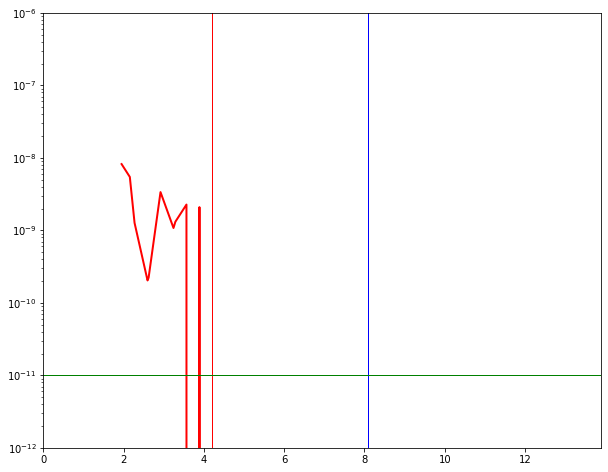

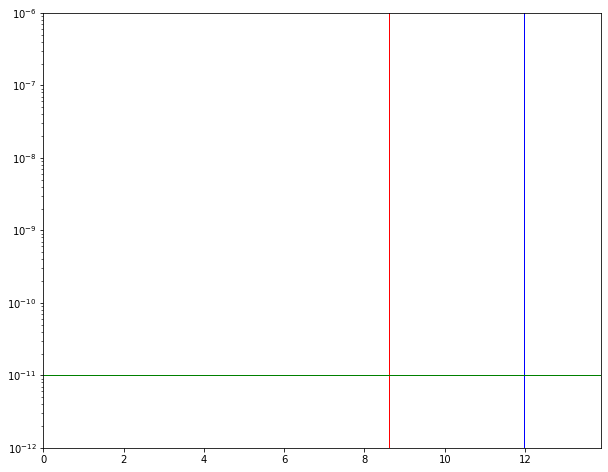

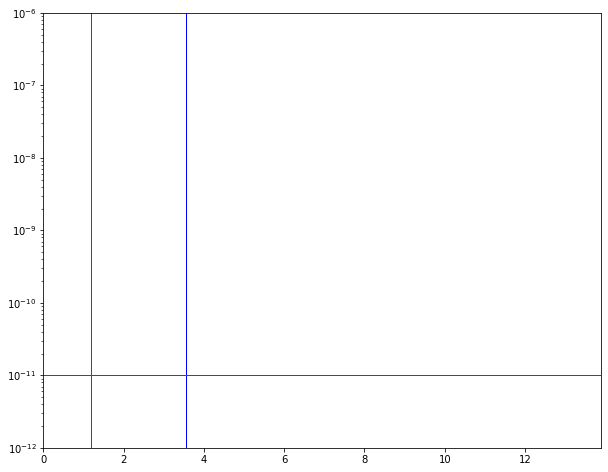

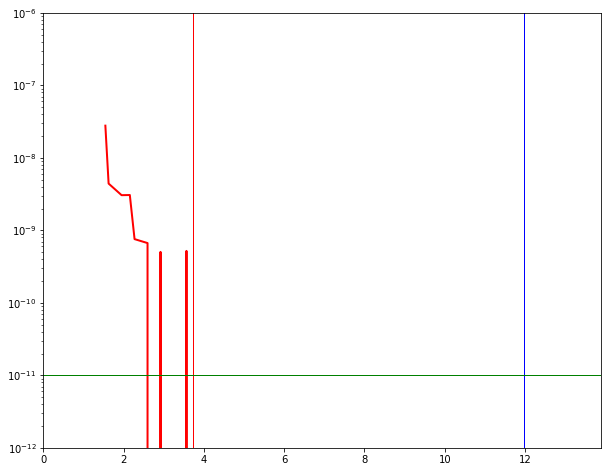

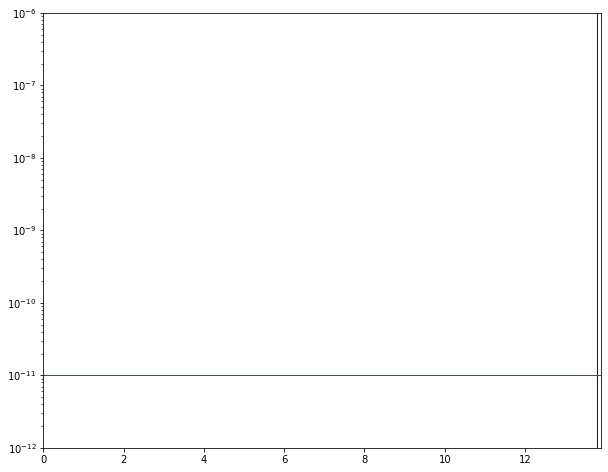

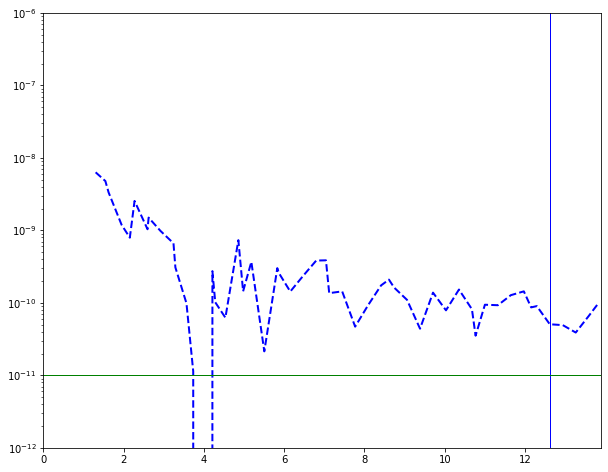

In [53]:
import warnings
warnings.filterwarnings('ignore')


cm = plt.cm.get_cmap('viridis')

for ID in myIDs:
    fig, (ax1) = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(10, 8))
    fig.set_facecolor('w')
    np.seterr(divide='ignore')
    t_quench, sSFR, t_Gyr, t_infall, Mstar = quenching_time(ID=ID, threshold=1e-11)
    a = np.zeros(len(sSFR))
    for i in range(1, len(sSFR)-1):
        a[i] = np.average([sSFR[i-1], sSFR[i], sSFR[i+1]])
    #a = sSFR#.reshape(-1, 2).mean(axis=1)
    if t_quench == -1:
        ax1.plot(t_Gyr, sSFR, lw=2, color='blue', ls='--')
    if t_quench > 0:
        ax1.plot(t_Gyr, sSFR, lw=2, color='red')
        ax1.axvline(t_quench, lw=1, color='red')
    ax1.set_yscale('log')
    
    ax1.axvline(t_infall, lw=1, color='blue')
    ax1.axhline(1e-11, lw=1, color='green')
    ax1.set_xlim(0, 13.9)
    ax1.set_ylim(1e-12, 1e-6)
# I cannot trust SFR calculated by pynbody
# Will calculate my own SFR at each timestep

In [55]:
t_Gyr[-1]

13.800797497330507

NameError: name 'h148_survivors' is not defined

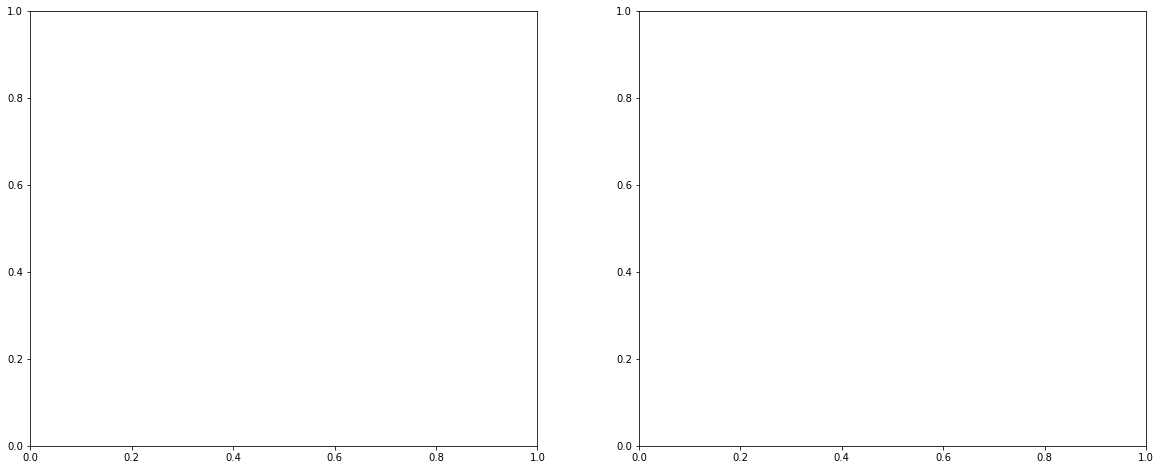

In [19]:
import warnings
warnings.filterwarnings('ignore')

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(20, 8))
fig.set_facecolor('w')
np.seterr(divide='ignore')
cm = plt.cm.get_cmap('viridis')

for ID in myIDs:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(ID=ID, simulation='h148', status='Survivor', 
                                                  tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    #if sSFR length even, reshape 2
    #if sSFR length off, append 0 and reshaoe 2
    #then avg over adjacent pairs to smooth
    a = sSFR.reshape(-1, 2).mean(axis=1)
    if t_quench == -1:
        ax1.plot(t_Gyr, a, color='blue', lw=0.8)
    if t_quench > 0:
        ax1.plot(t_Gyr, a, color='red', lw=0.8)
for sat in h229_survivors:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h229', status='Survivor', 
                                                  tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax1.plot(t_Gyr, sSFR, color='blue', lw=0.8)
    if t_quench > 0:
        ax1.plot(t_Gyr, sSFR, color='red', lw=0.8)
for sat in h242_survivors:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h242', status='Survivor', 
                                                  tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax1.plot(t_Gyr, sSFR, color='blue', lw=0.8)
    if t_quench > 0:
        ax1.plot(t_Gyr, sSFR, color='red', lw=0.8)
for sat in h329_survivors:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h329', status='Survivor', 
                                                  tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax1.plot(t_Gyr, sSFR, color='blue', lw=0.8)
    if t_quench > 0:
        ax1.plot(t_Gyr, sSFR, color='red', lw=0.8)
ax1.axvline(0, color='black', ls='--', lw=2)
ax1.set_title('Survivors', fontsize=23)
ax1.set_ylabel('$\log \, M_*/M_\odot$', fontsize=23)
ax1.set_xlabel('Time Since Infall (Gyr)', fontsize=23)
ax1.set_xlim(-12, 12)
ax1.set_yscale('log')
ax1.set_ylim(1e-12, 1e-4)
ax1.tick_params(which='major', length=12)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)


for sat in h148_zombies:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h148', status='Zombie', 
                                           tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax2.plot(t_Gyr, sSFR, color='blue', lw=0.8, alpha=1)
    if t_quench > 0:
        ax2.plot(t_Gyr, sSFR, color='red', lw=0.8, alpha=1)
for sat in h229_zombies:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h229', status='Zombie', 
                                           tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax2.plot(t_Gyr, sSFR, color='blue', lw=0.8, alpha=1)
    if t_quench > 0:
        ax2.plot(t_Gyr, sSFR, color='red', lw=0.8, alpha=1)
for sat in h242_zombies:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h242', status='Zombie', 
                                           tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax2.plot(t_Gyr, sSFR, color='blue', lw=0.8, alpha=1)
    if t_quench > 0:
        ax2.plot(t_Gyr, sSFR, color='red', lw=0.8, alpha=1)
for sat in h329_zombies:
    t_quench, sSFR, t_Gyr, Mstar = quenching_time(simulation='h329', status='Zombie', 
                                           tangos_halo=sat, halo_id=0, snap_num=0, threshold=1e-11)
    if t_quench == -1:
        ax2.plot(t_Gyr, sSFR, color='blue', lw=0.8, alpha=1)
    if t_quench > 0:
        ax2.plot(t_Gyr, sSFR, color='red', lw=0.8, alpha=1)
ax2.axvline(0, color='black', ls='--', lw=2)
ax2.set_title('Zombies', fontsize=23)
ax2.set_ylabel('$\log \, M_*/M_\odot$', fontsize=23)
ax2.set_xlabel('Time Since Infall (Gyr)', fontsize=23)
ax2.set_xlim(-7.5, 3)
ax2.set_ylim(1e-12, 1e-4)
ax2.set_yscale('log')
ax2.tick_params(which='major', length=12)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)

fig.tight_layout()